In [1]:
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

os.environ["RUNFILES_DIR"] = "/Library/Frameworks/Python.framework/Versions/3.7/share/plaidml"
# plaidml might exist in different location. Look for "/usr/local/share/plaidml" and replace in above path

#os.environ["PLAIDML_NATIVE_PATH"] = "/Library/Frameworks/Python.framework/Versions/3.7/lib/libplaidml.dylib"
os.environ["PLAIDML_NATIVE_PATH"] = "/anaconda3/lib/libplaidml.dylib"
# libplaidml.dylib might exist in different location. Look for "/usr/local/lib/libplaidml.dylib" and replace in above path

In [2]:
import plaidml.keras
plaidml.keras.install_backend()

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam


In [4]:
train_dir = 'gan_images'



In [5]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

targetsize=32

batchsize=64

latentdim=1000

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(targetsize,targetsize),
        batch_size=batchsize,
        class_mode='categorical')


Found 539 images belonging to 1 classes.


In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    break

data batch shape:  (64, 32, 32, 3)
labels batch shape:  (64, 1)


In [7]:
inputt,outputt = next(train_generator)

In [8]:
inputt.shape

(64, 32, 32, 3)

In [9]:
 inputt.shape==(batchsize,targetsize,targetsize,3)

True

In [10]:
outputt.shape

(64, 1)

In [11]:
inputt2=np.reshape(inputt,(batchsize,targetsize*targetsize*3))

In [12]:
inputt2.shape

(64, 3072)

In [13]:
# def load_data():
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
#     # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
#     # 784 columns per row
#     x_train = x_train.reshape(60000, 784)
#     return (x_train, y_train, x_test, y_test)
# (X_train, y_train,X_test, y_test)=load_data()
# print(X_train.shape)

def adam_optimizer():
    return adam()

In [14]:
def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=latentdim))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=256))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=targetsize*targetsize*3, activation='sigmoid'))
    
    generator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return generator

g=create_generator()
g.summary()

INFO:plaidml:Opening device "metal_amd_radeon_pro_560x.0"


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               256256    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
__________

In [15]:
def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=targetsize*targetsize*3))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.2))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=128))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=adam_optimizer())
    return discriminator

d =create_discriminator()
d.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
__________

In [16]:
 def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(latentdim,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 3072)              3997184   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 3901697   
Total params: 7,898,881
Trainable params: 3,997,184
Non-trainable params: 3,901,697
_________________________________________________________________


In [17]:
def plot_generated_images(epoch, generator,  dim=(12,12), figsize=(20,20)):
    noise= np.random.normal(loc=0, scale=1, size=[batchsize, latentdim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(batchsize,targetsize,targetsize,3)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    #plt.savefig('gan_generated_image %d.png' %epoch)

In [18]:

def training(epochs=1, batch_size=batchsize):
    
    #Loading the data
    # batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        print("Epoch %d" %e)
        for _ in range(int(5805/batch_size)):
            if _%10==0:
                print(_/(58.05/batch_size),"%")
        #generate  random noise as an input  to  initialize the  generator
            noise= np.random.normal(0,1, [batch_size, latentdim])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # get next group of values
            inputt,outputt = next(train_generator)
            while inputt.shape!=(batch_size,targetsize,targetsize,3):
                inputt,outputt = next(train_generator)
               # print(inputt.shape)
      
                    
            inputt2=np.reshape(inputt,(batch_size,targetsize*targetsize*3))
            
            # Get a random set of  real images
            
            image_batch = inputt2
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size)
            y_dis[:batch_size]=1.0
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, latentdim])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
 
           
        plot_generated_images(e, generator)





Epoch 1
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


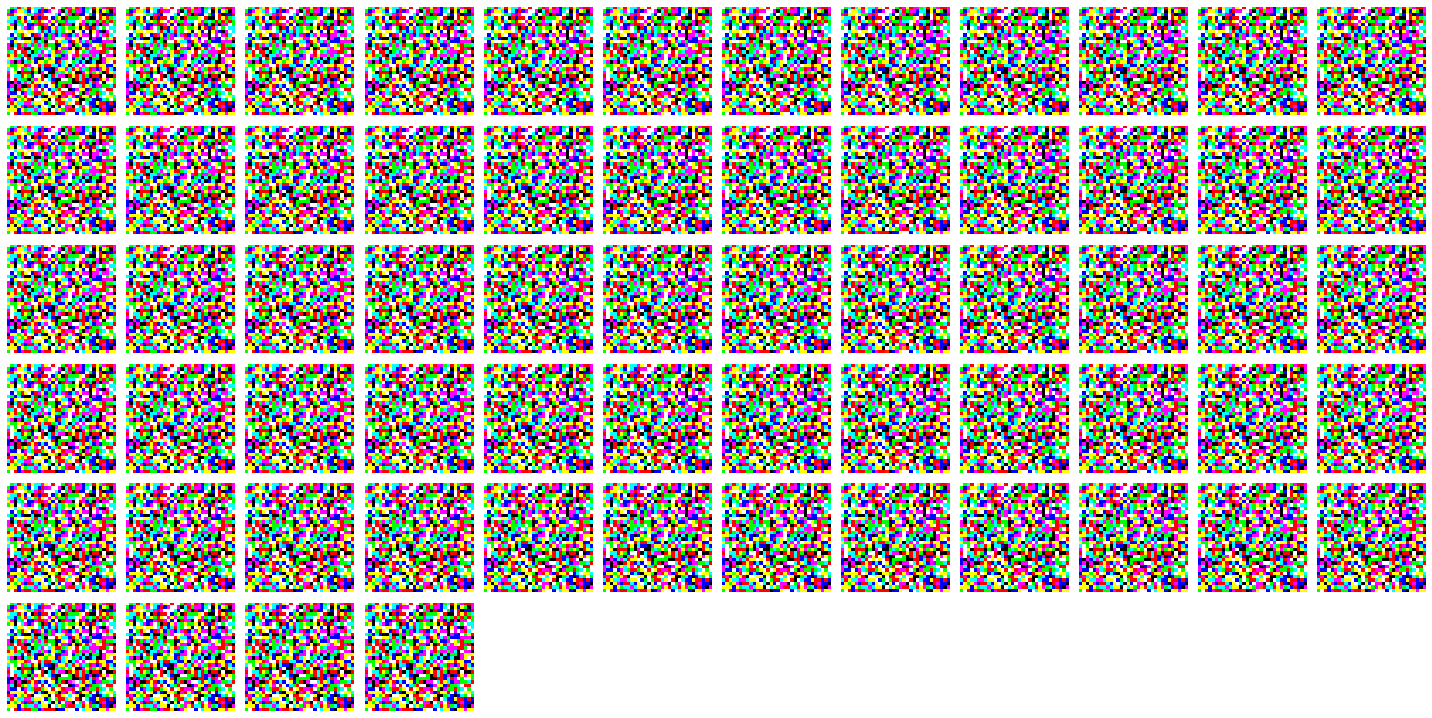

Epoch 2
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


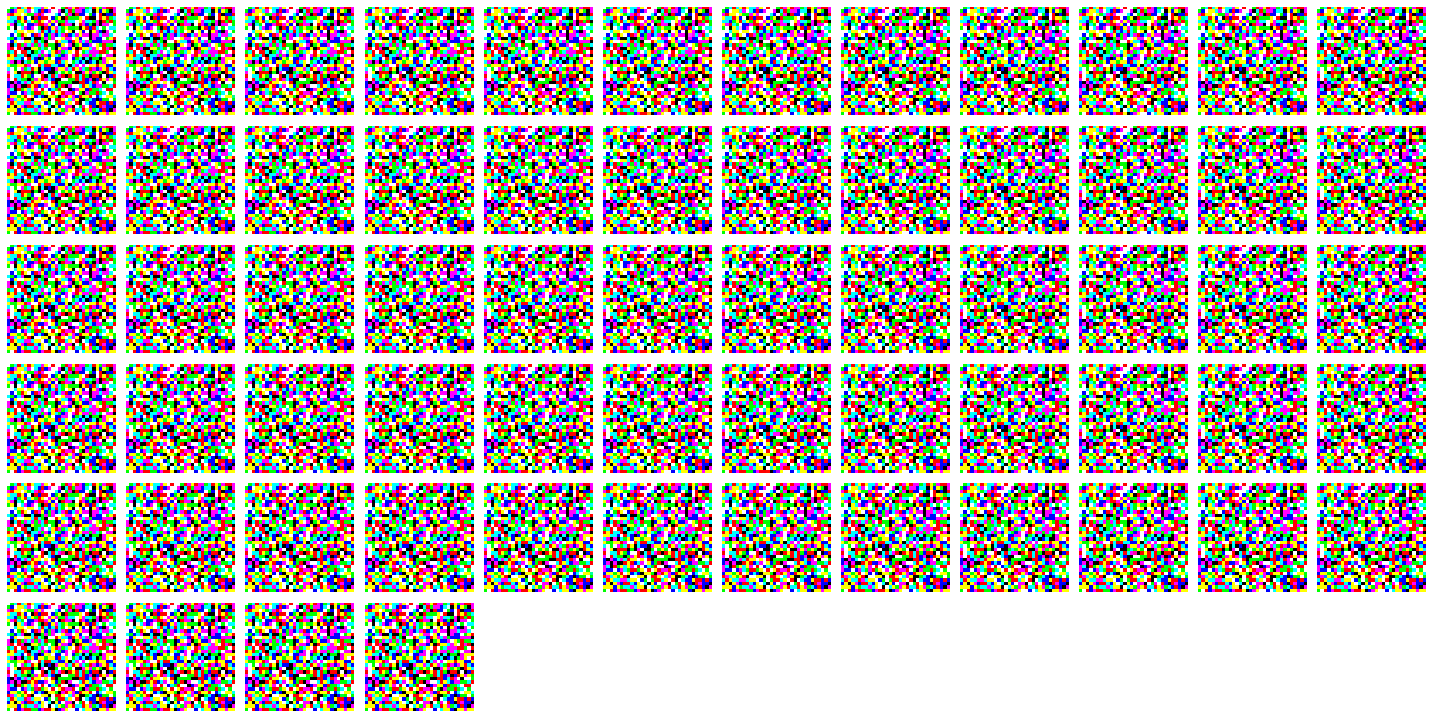

Epoch 3
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


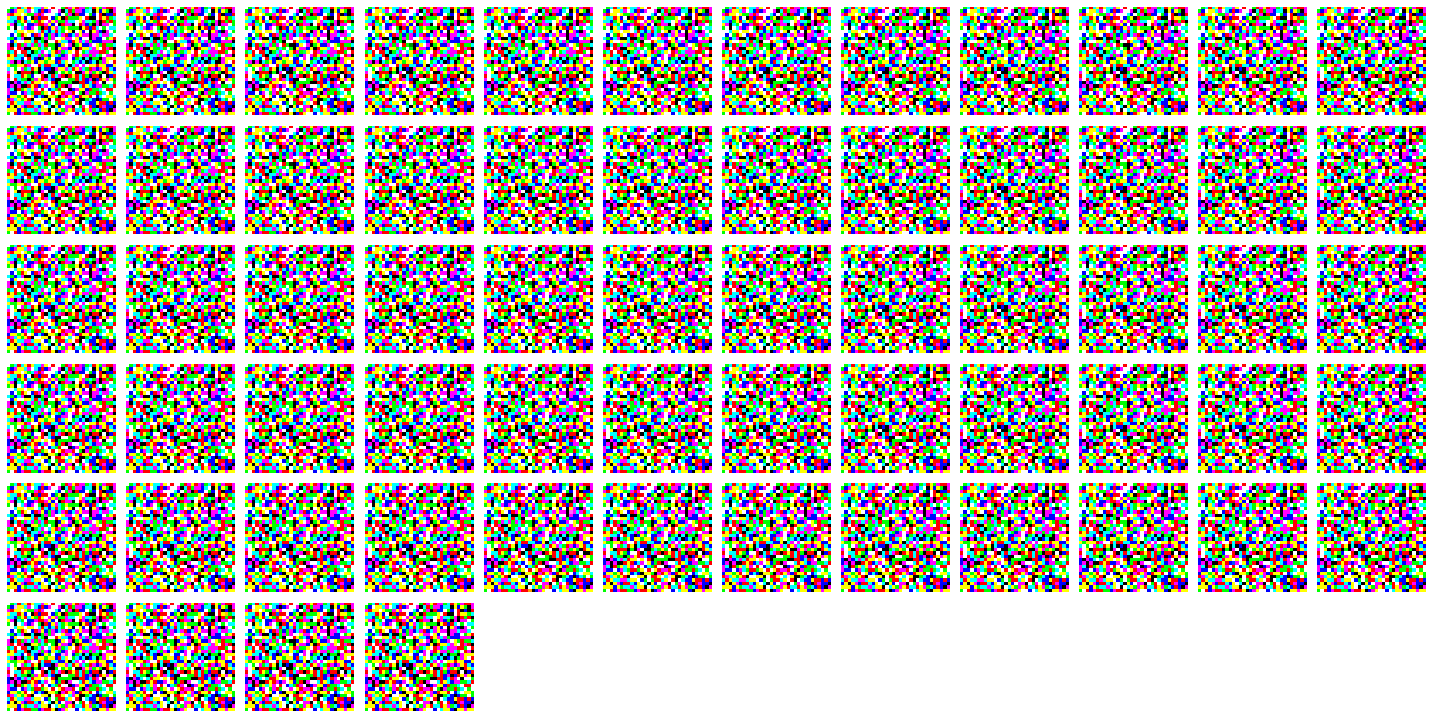

Epoch 4
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


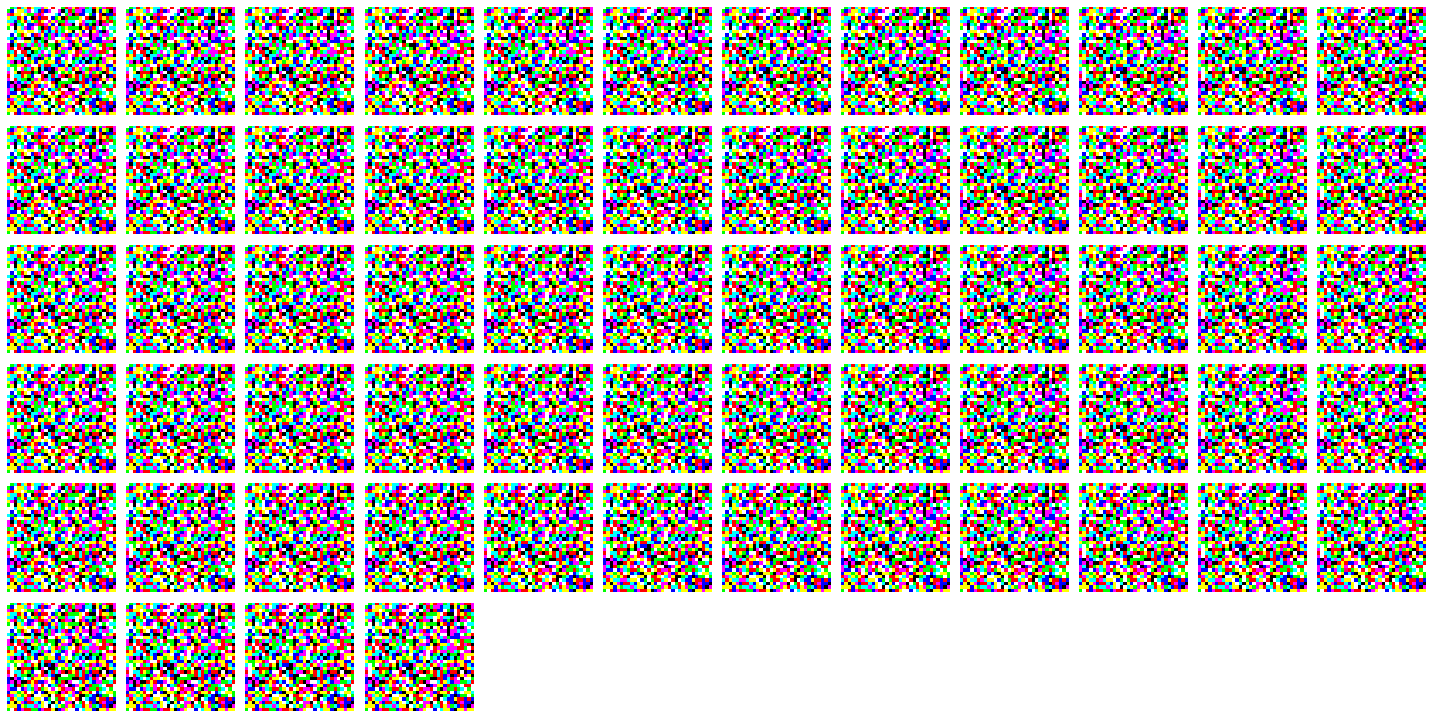

Epoch 5
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


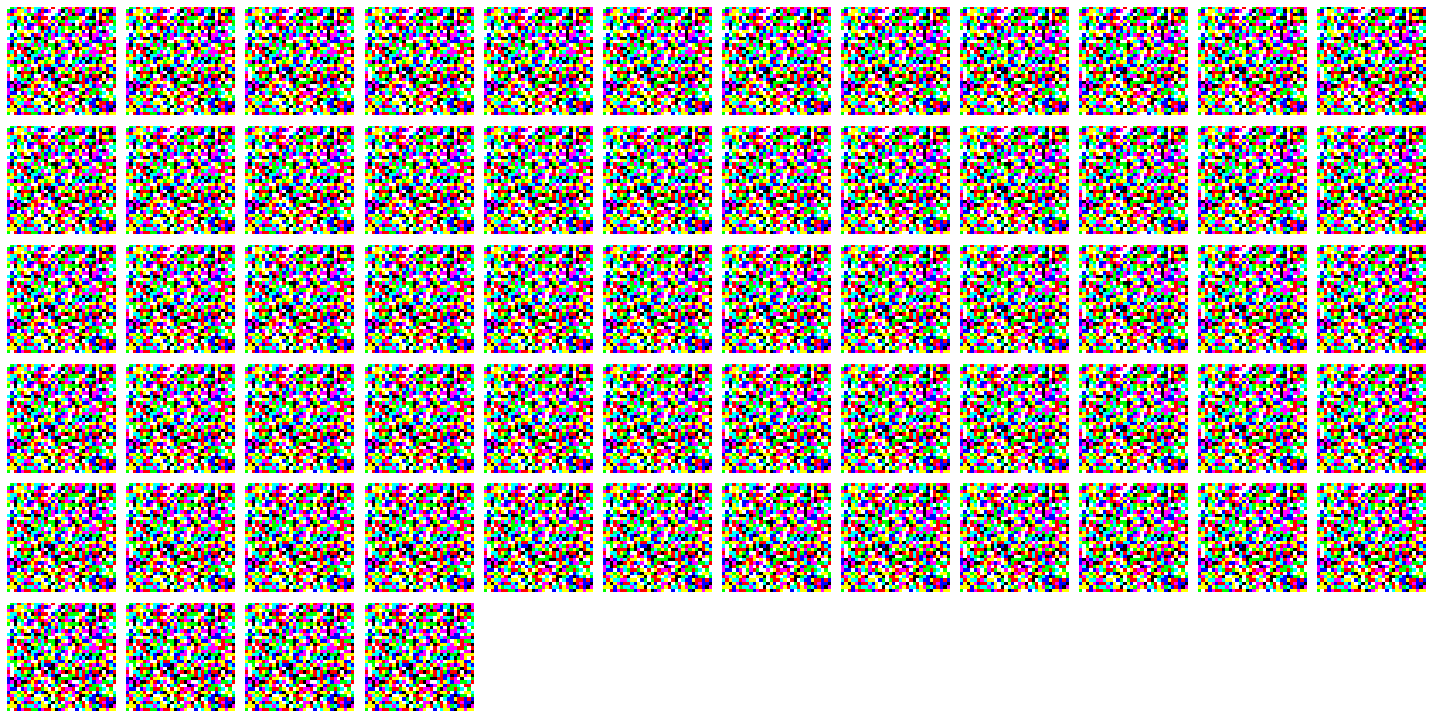

Epoch 6
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


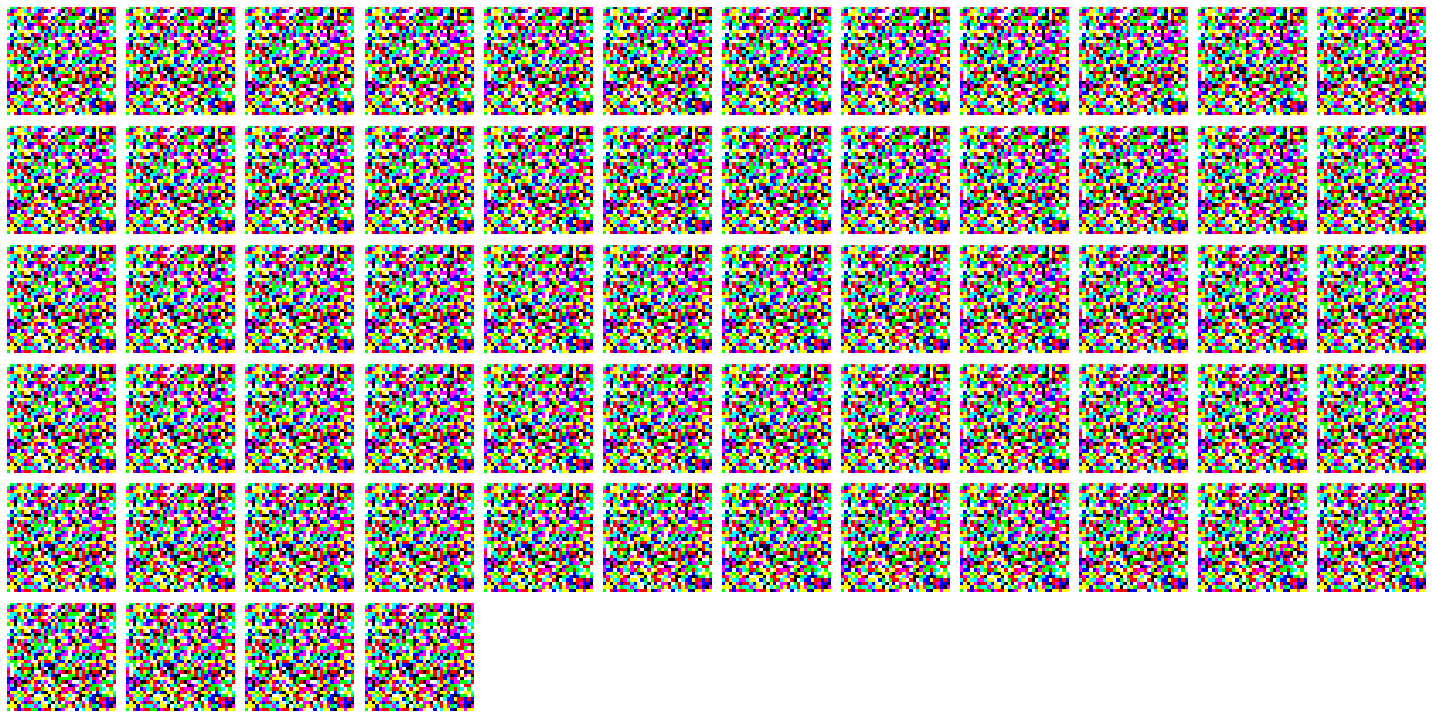

Epoch 7
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


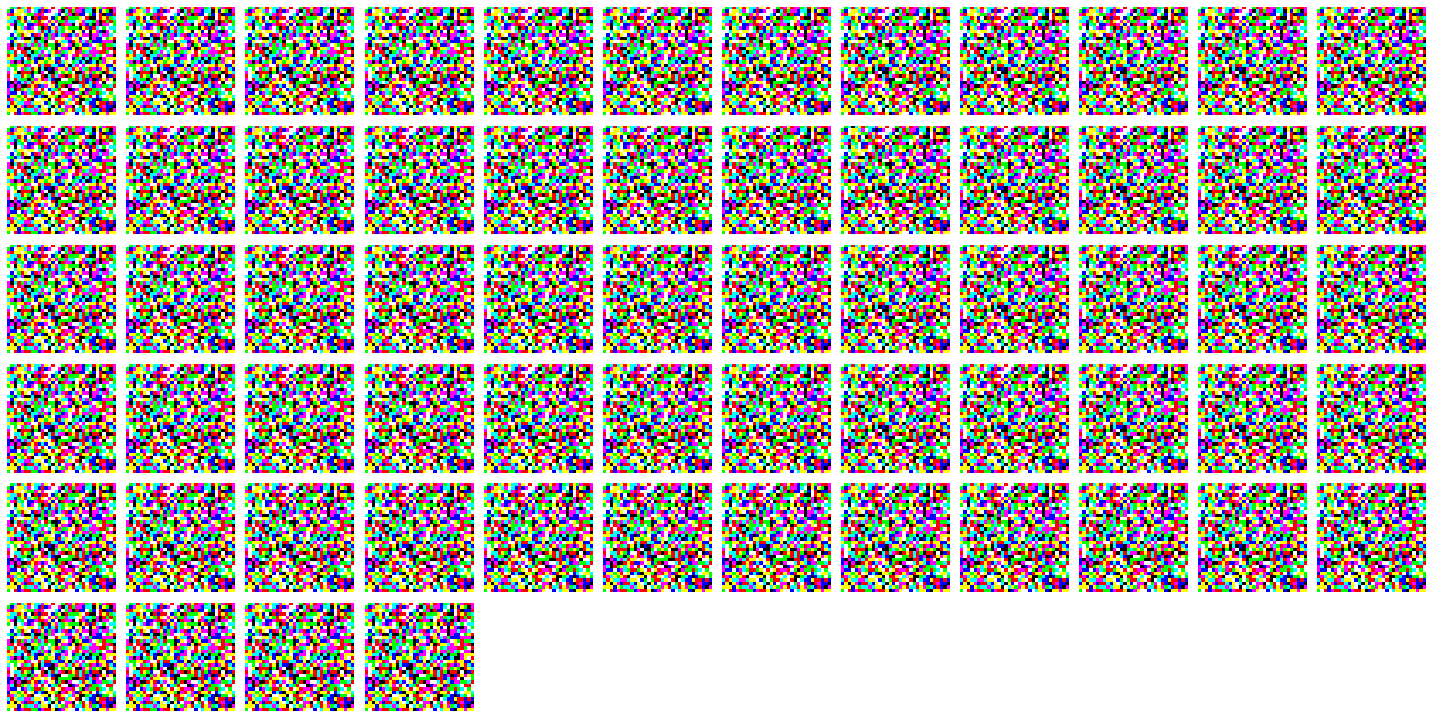

Epoch 8
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


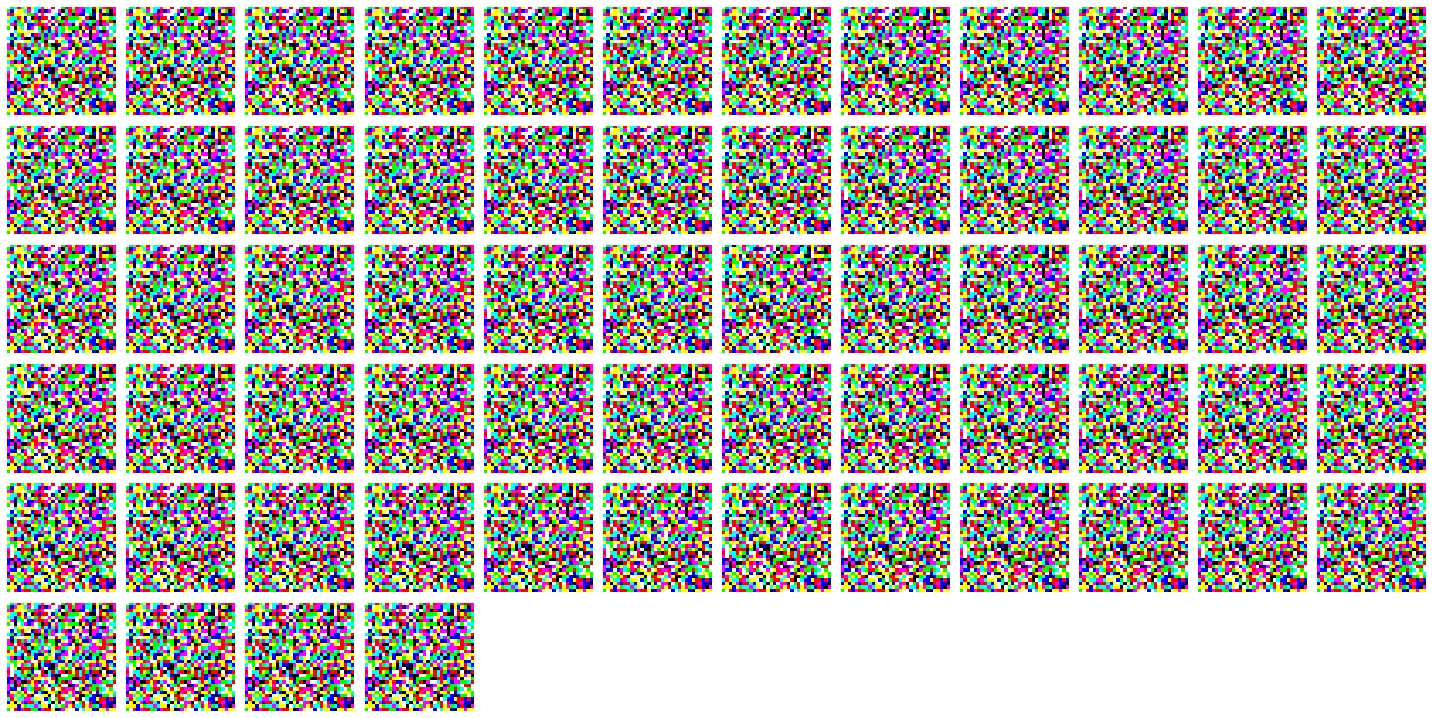

Epoch 9
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


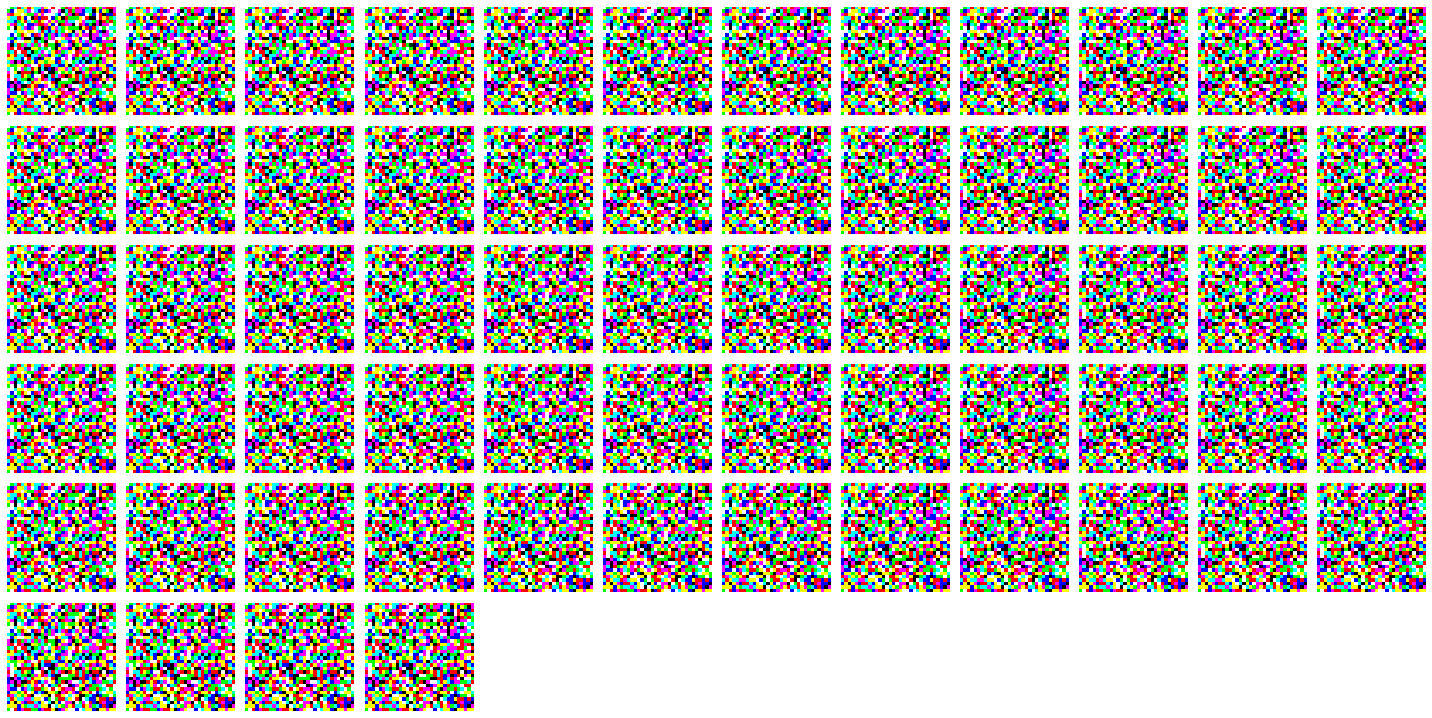

Epoch 10
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


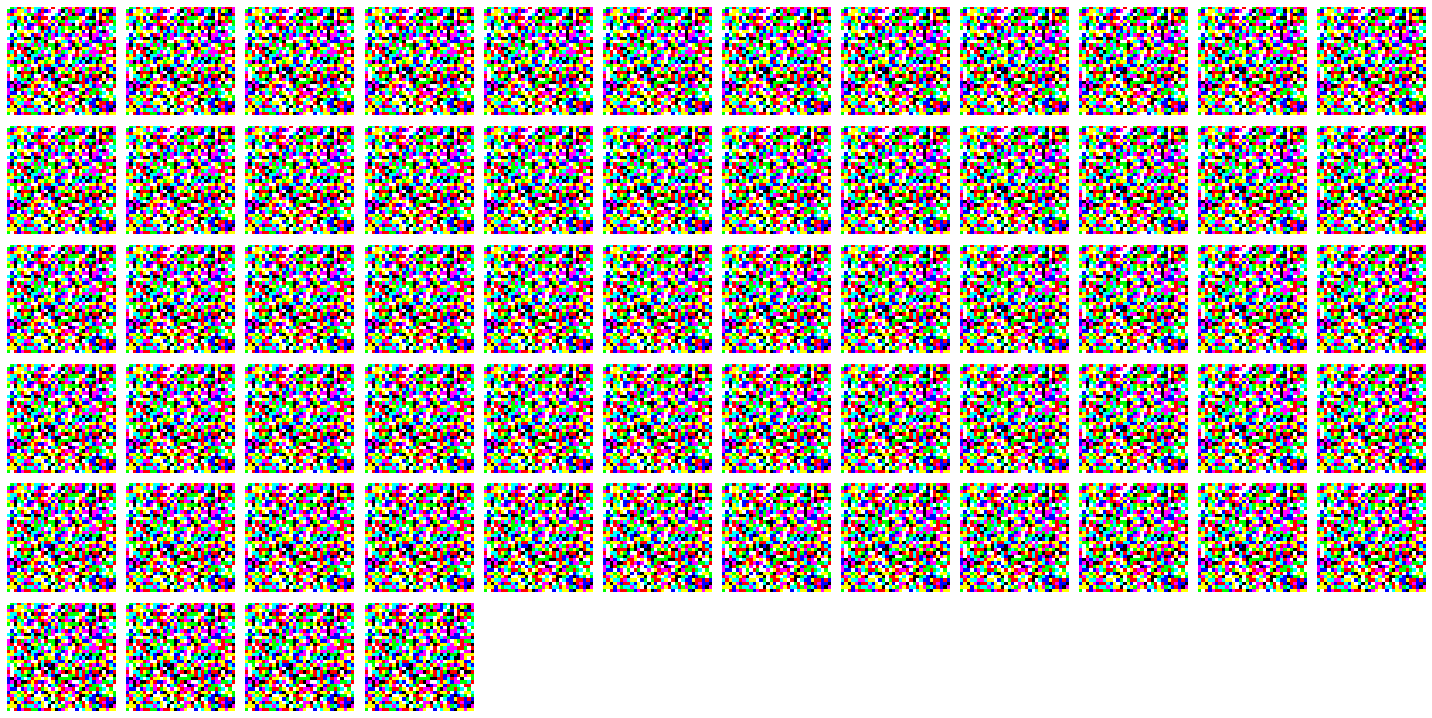

Epoch 11
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


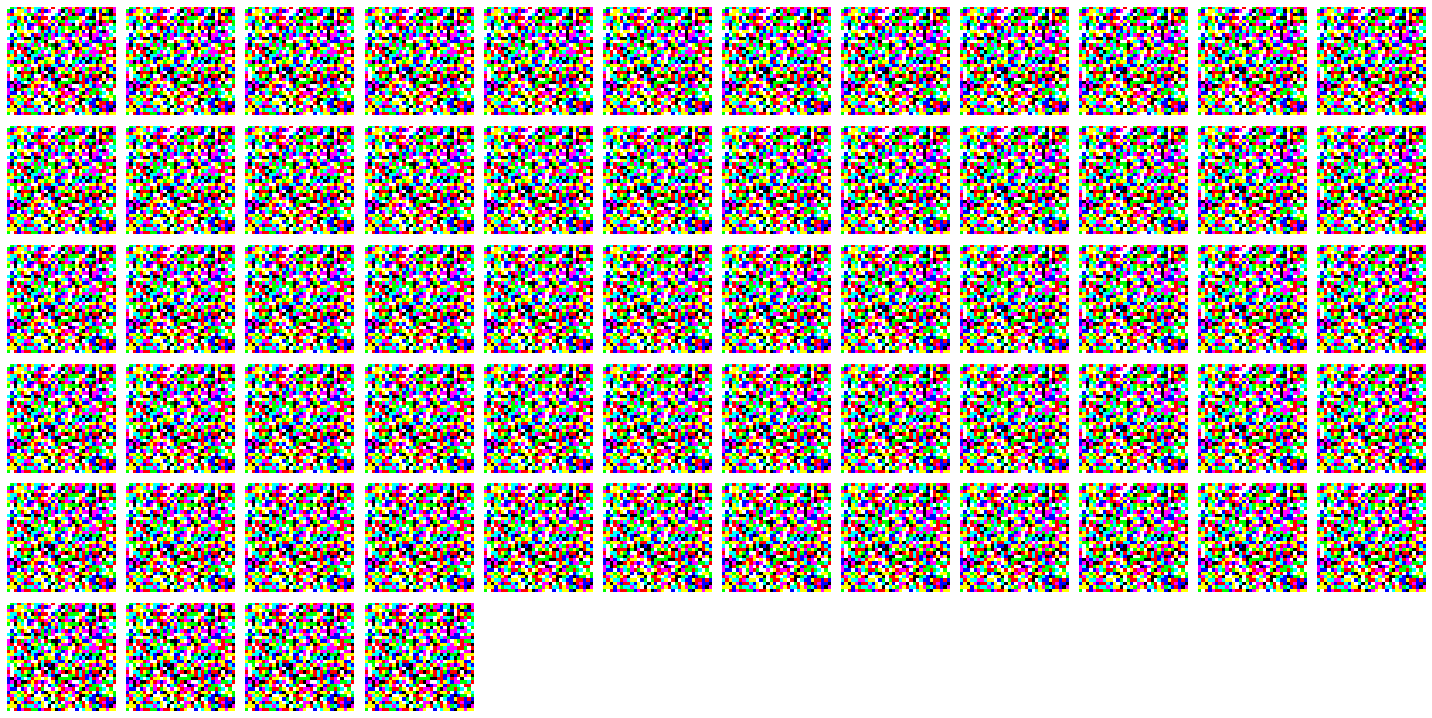

Epoch 12
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


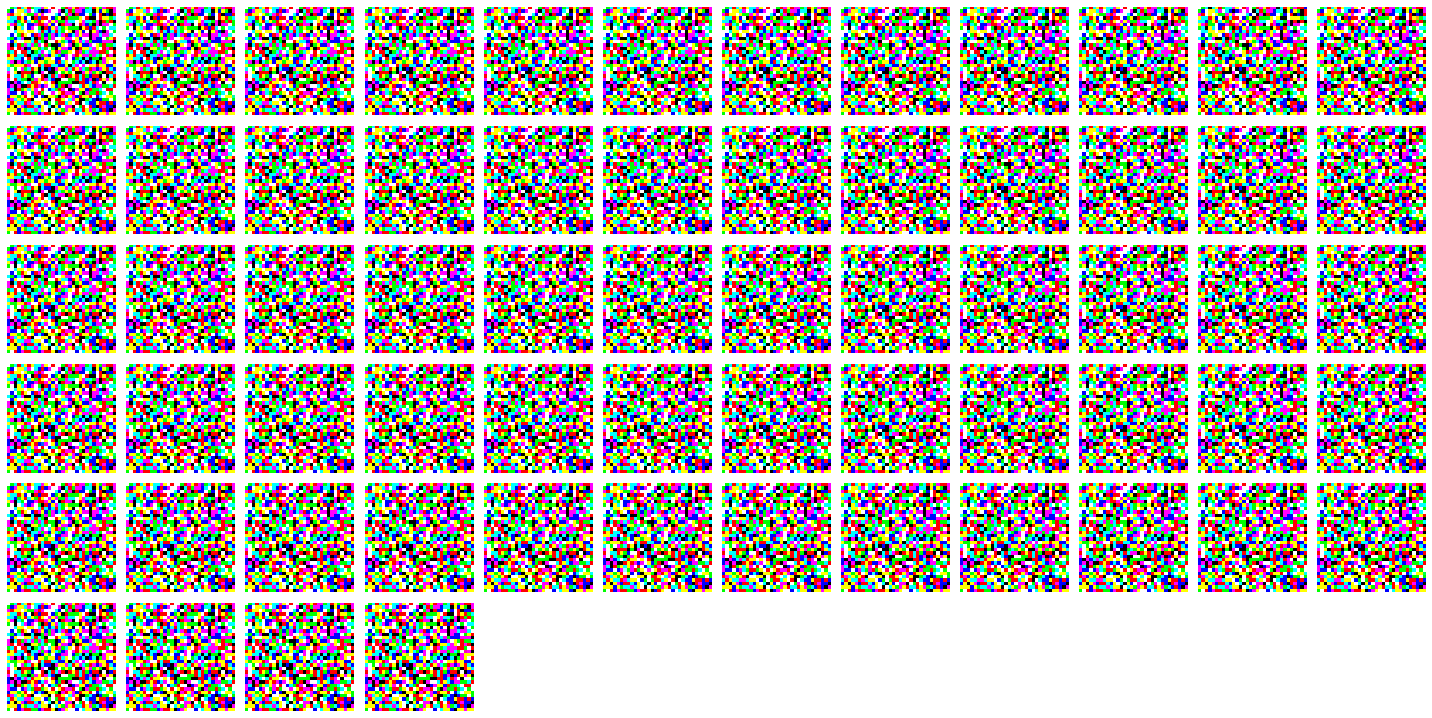

Epoch 13
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


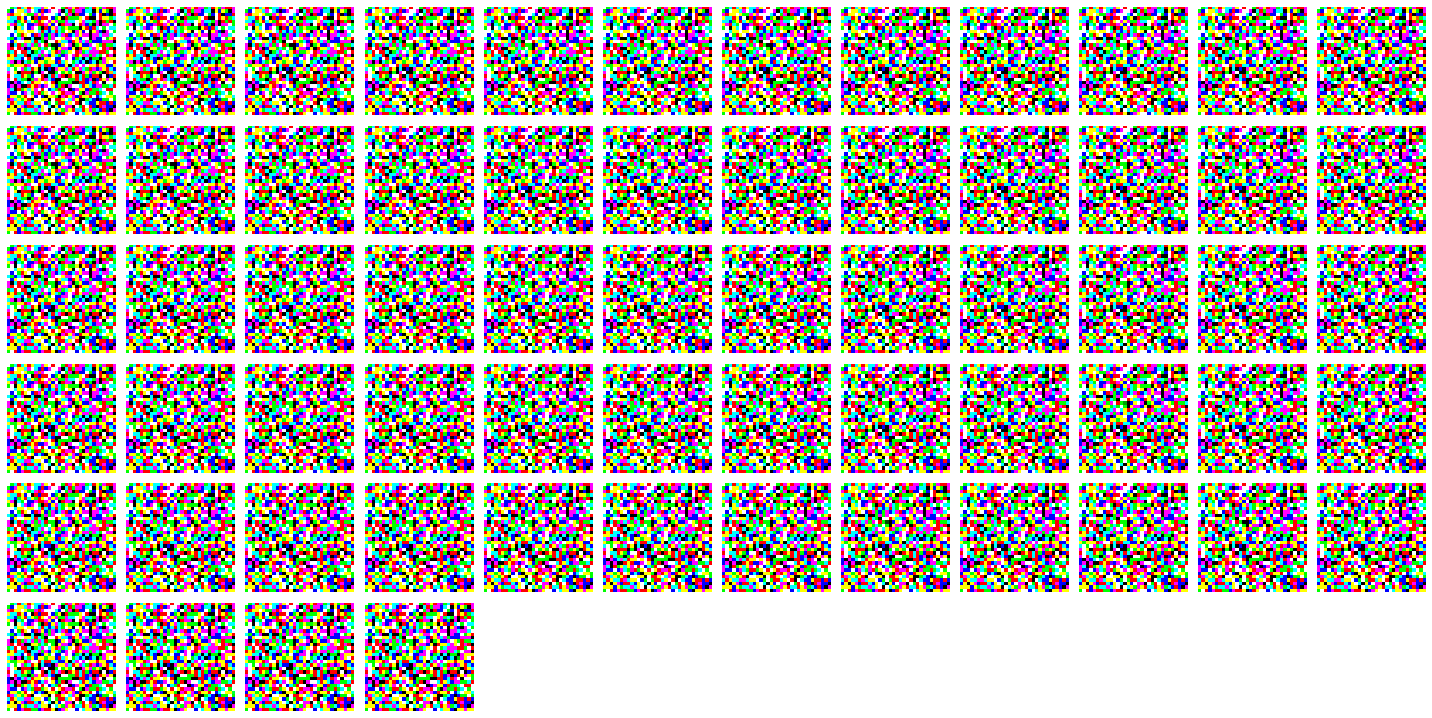

Epoch 14
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


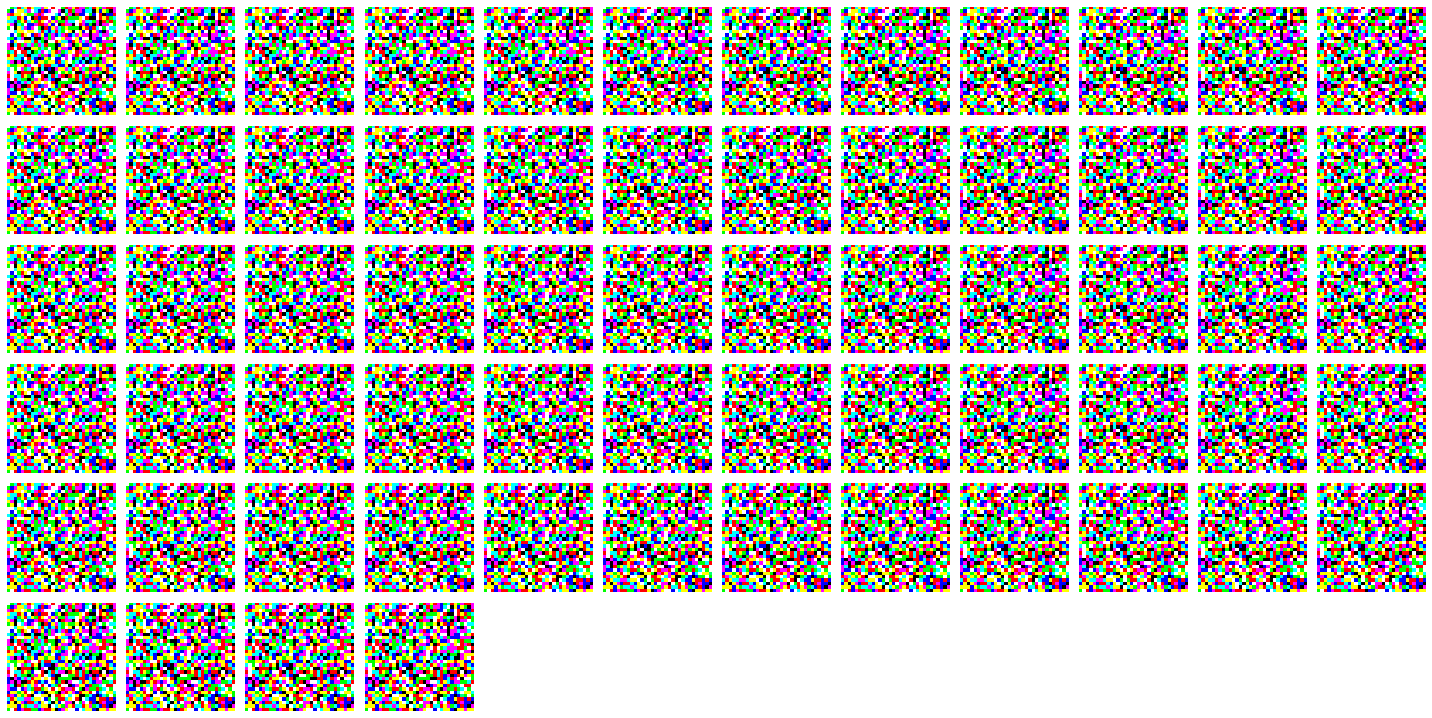

Epoch 15
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


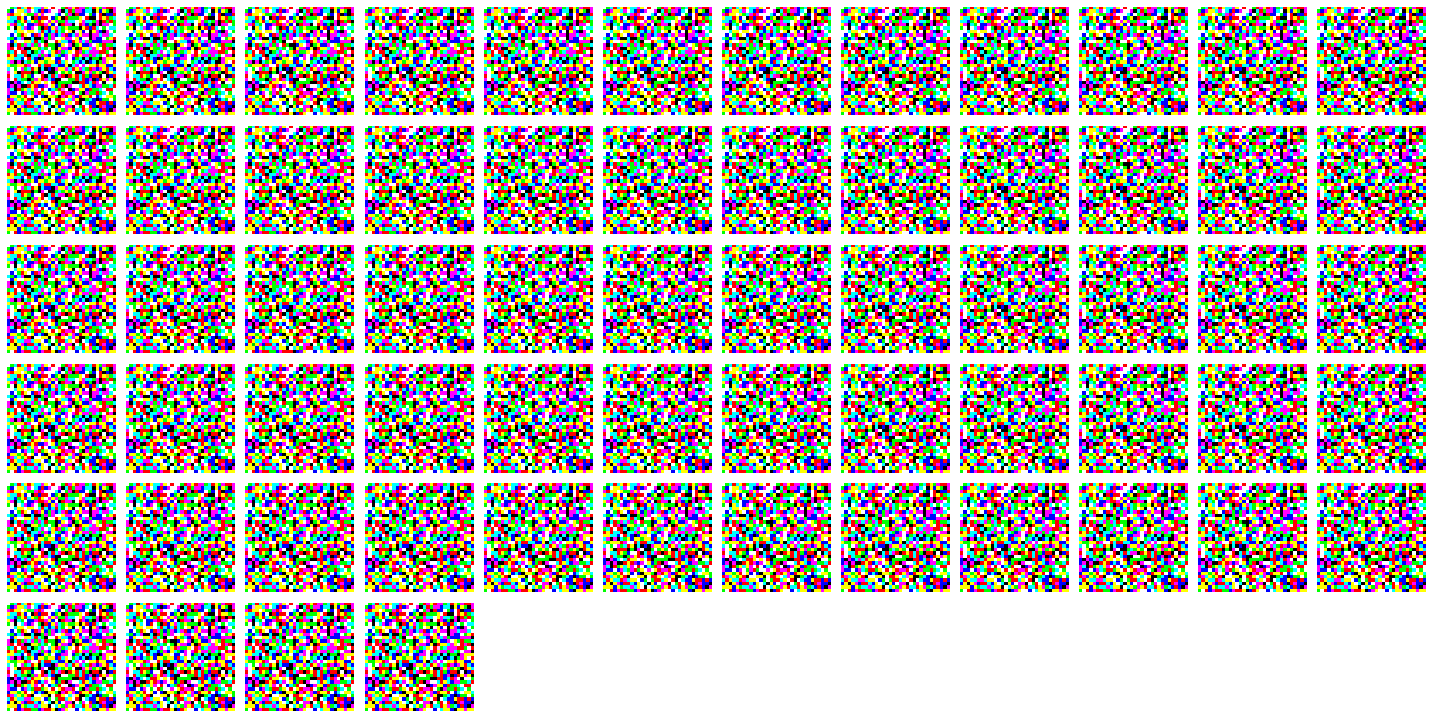

Epoch 16
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


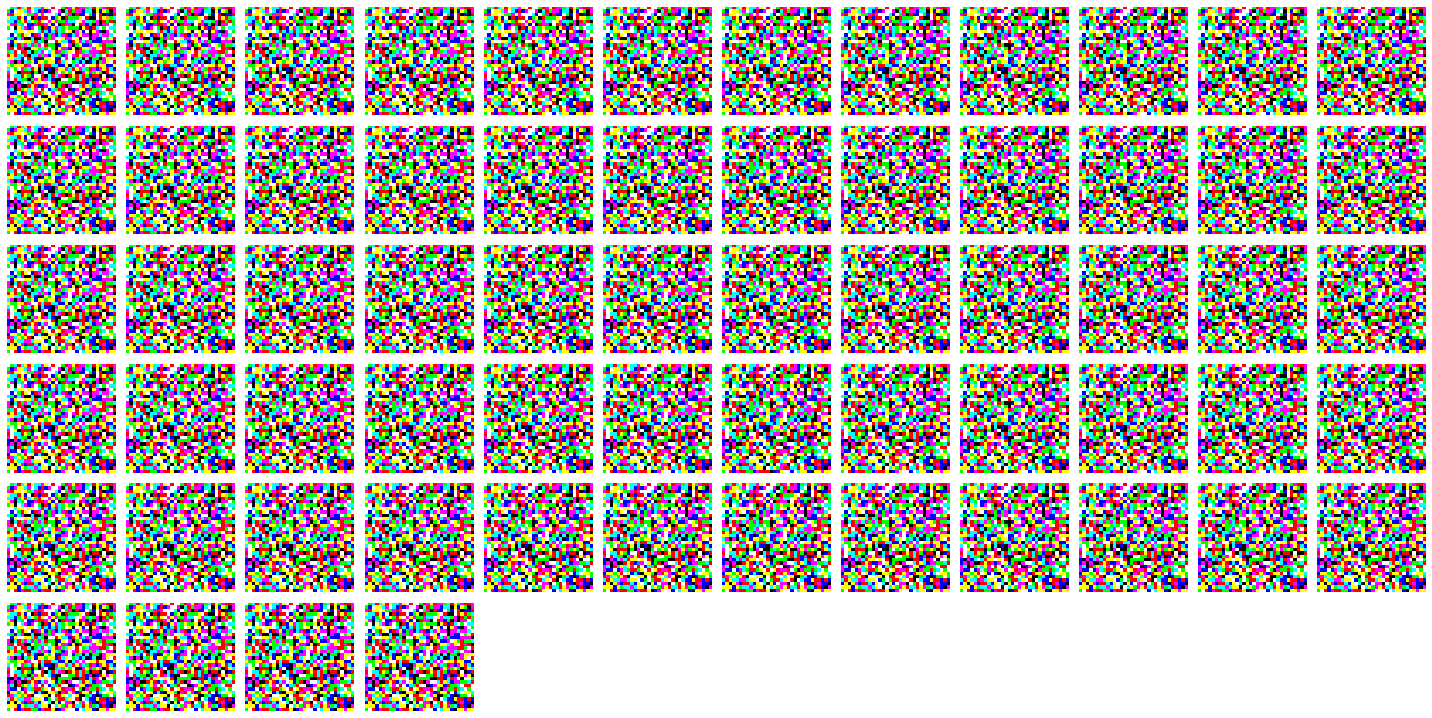

Epoch 17
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


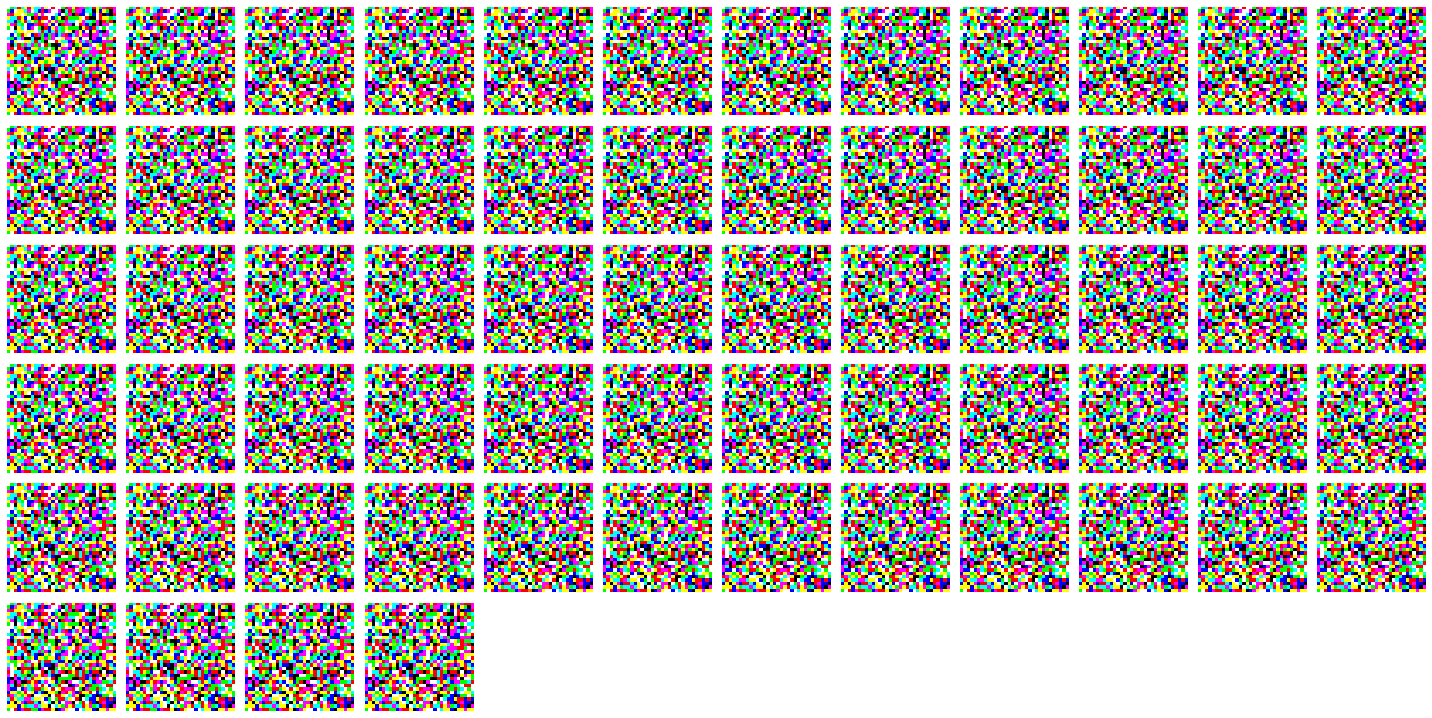

Epoch 18
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


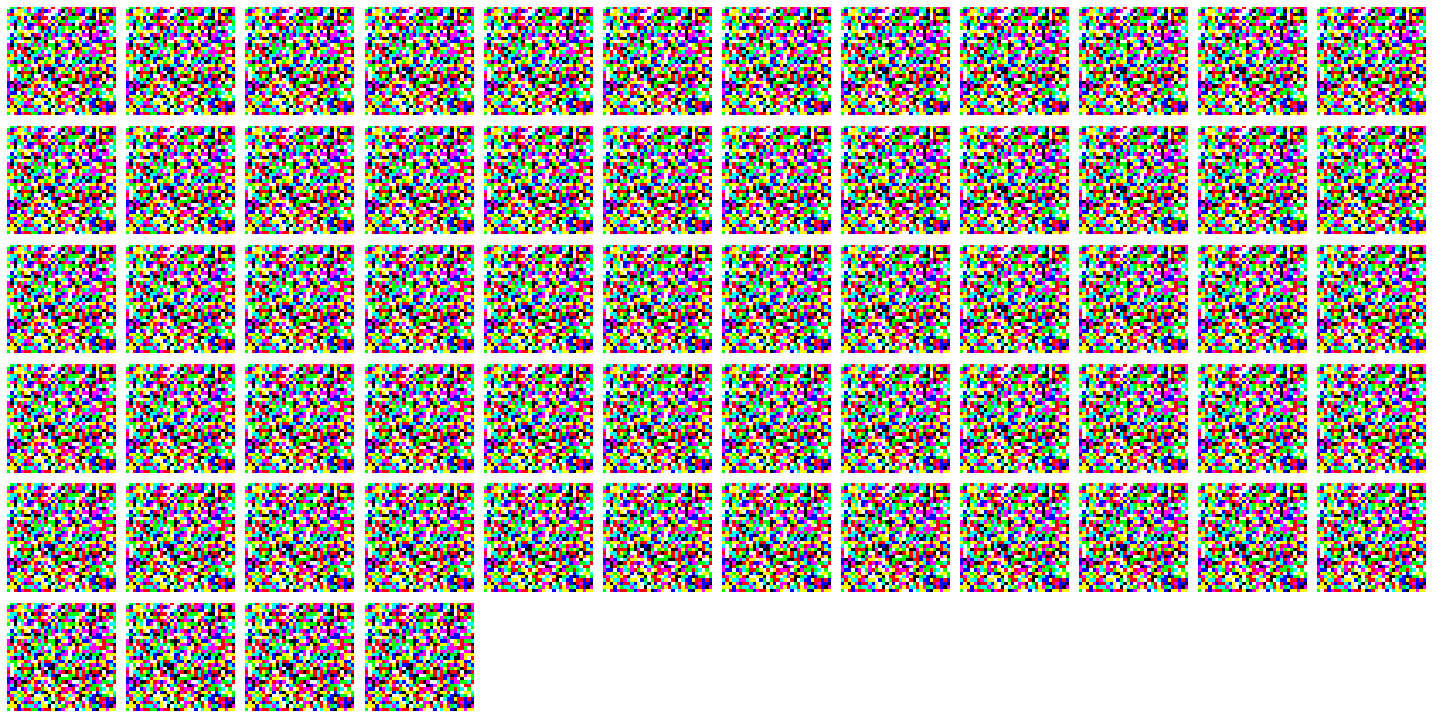

Epoch 19
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


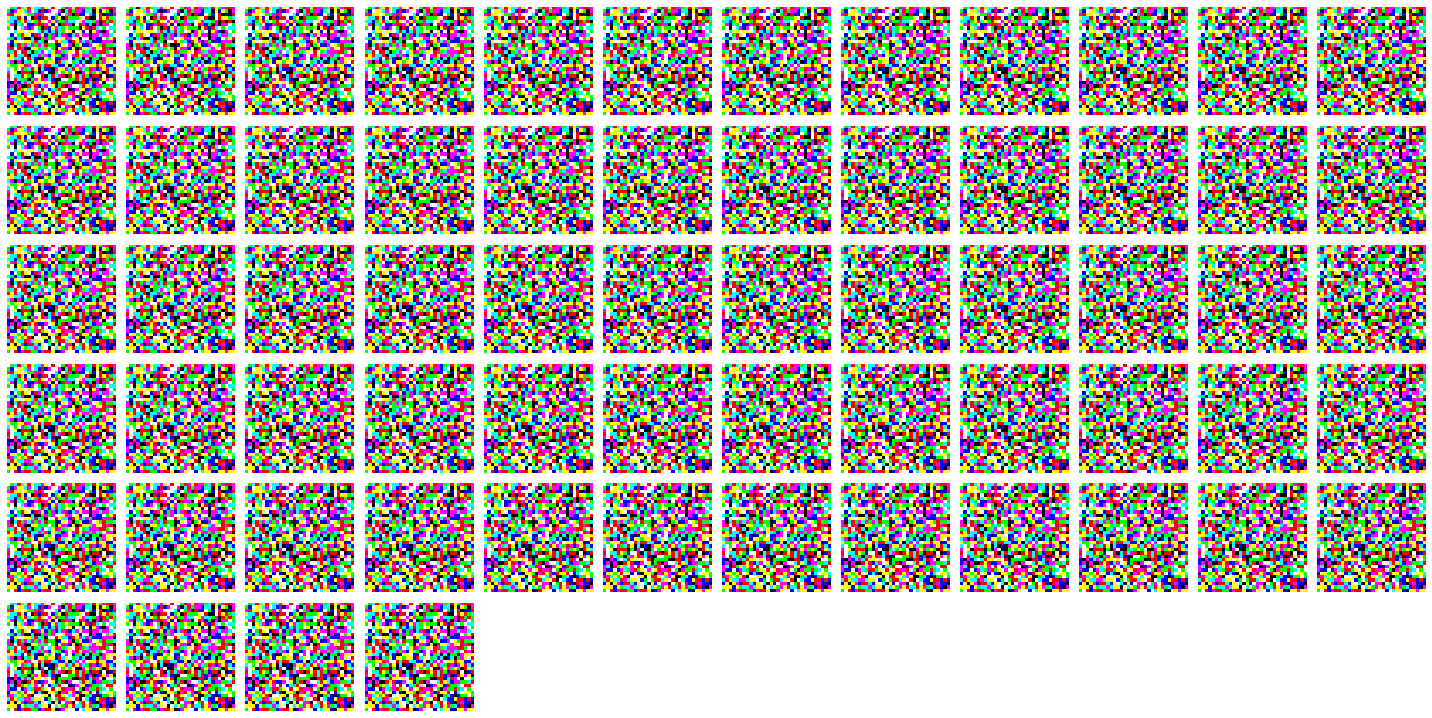

Epoch 20
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


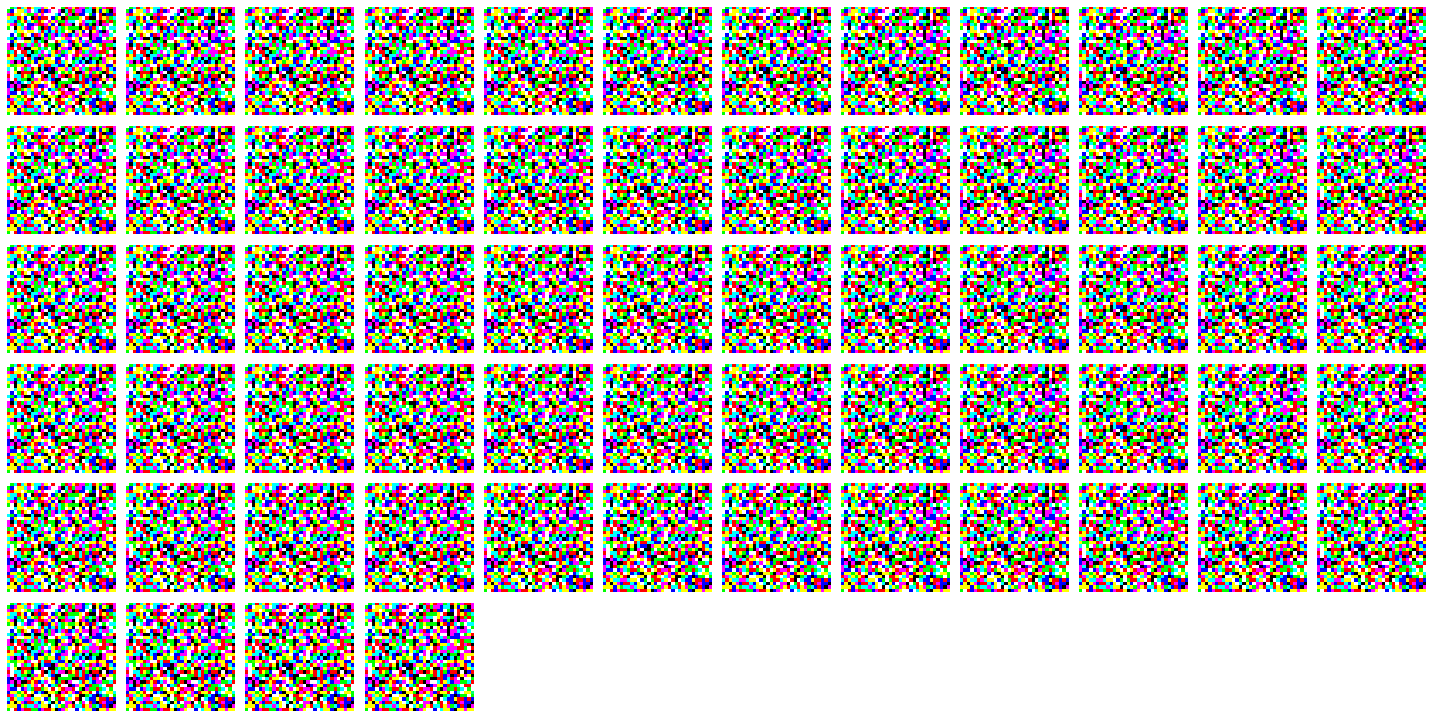

Epoch 21
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


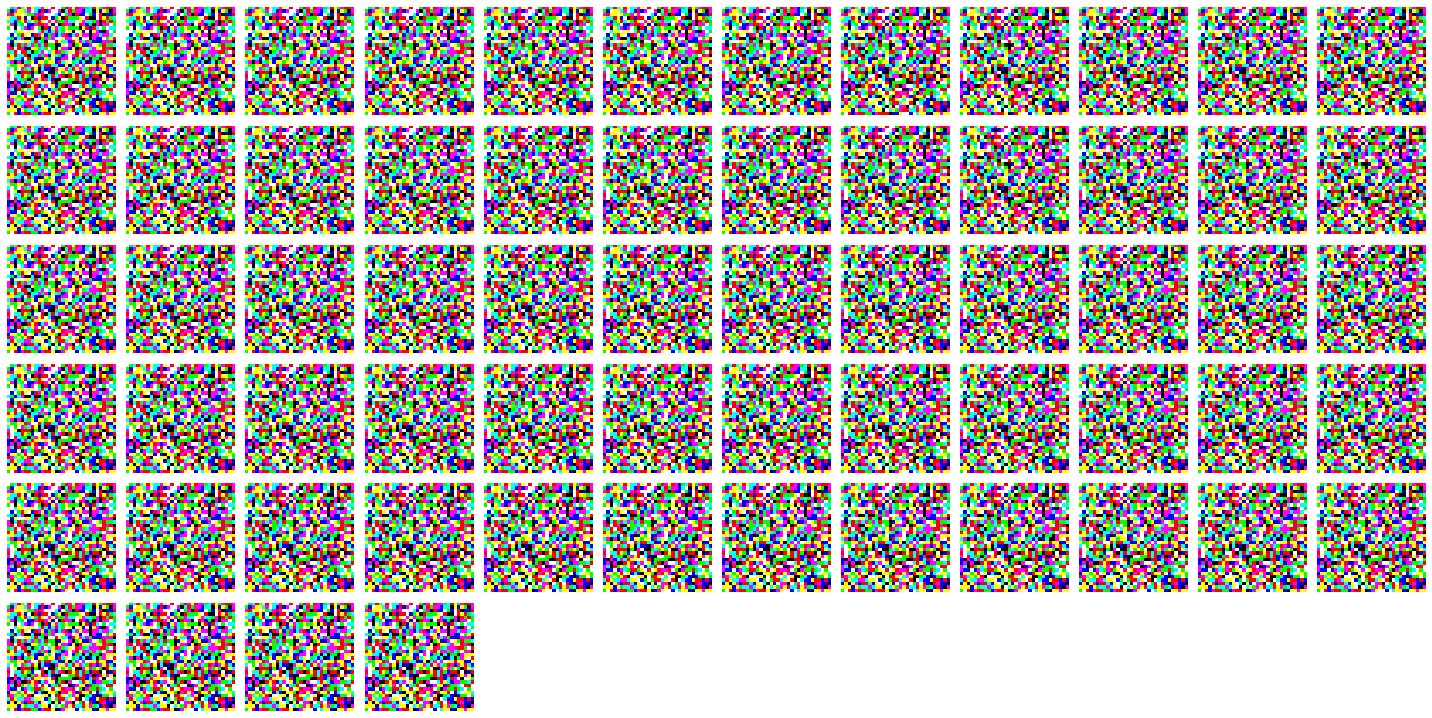

Epoch 22
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


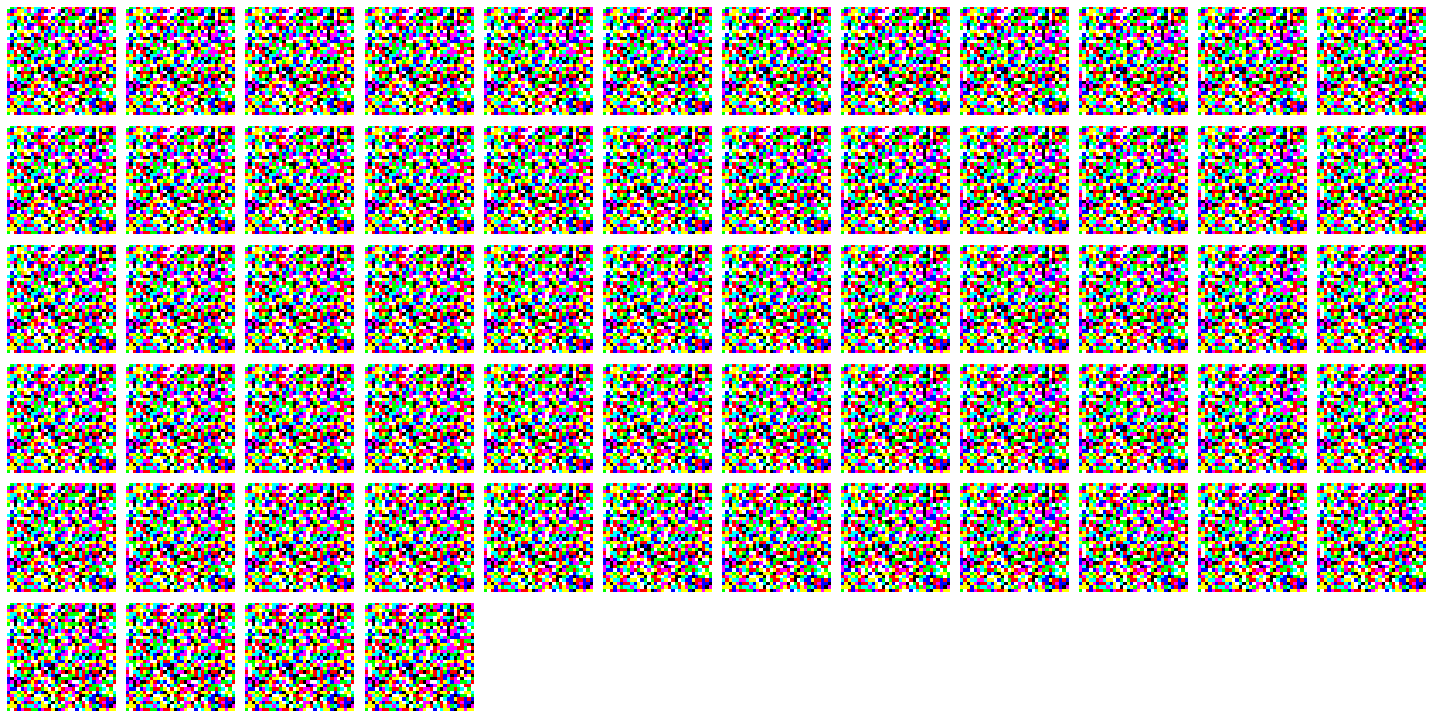

Epoch 23
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


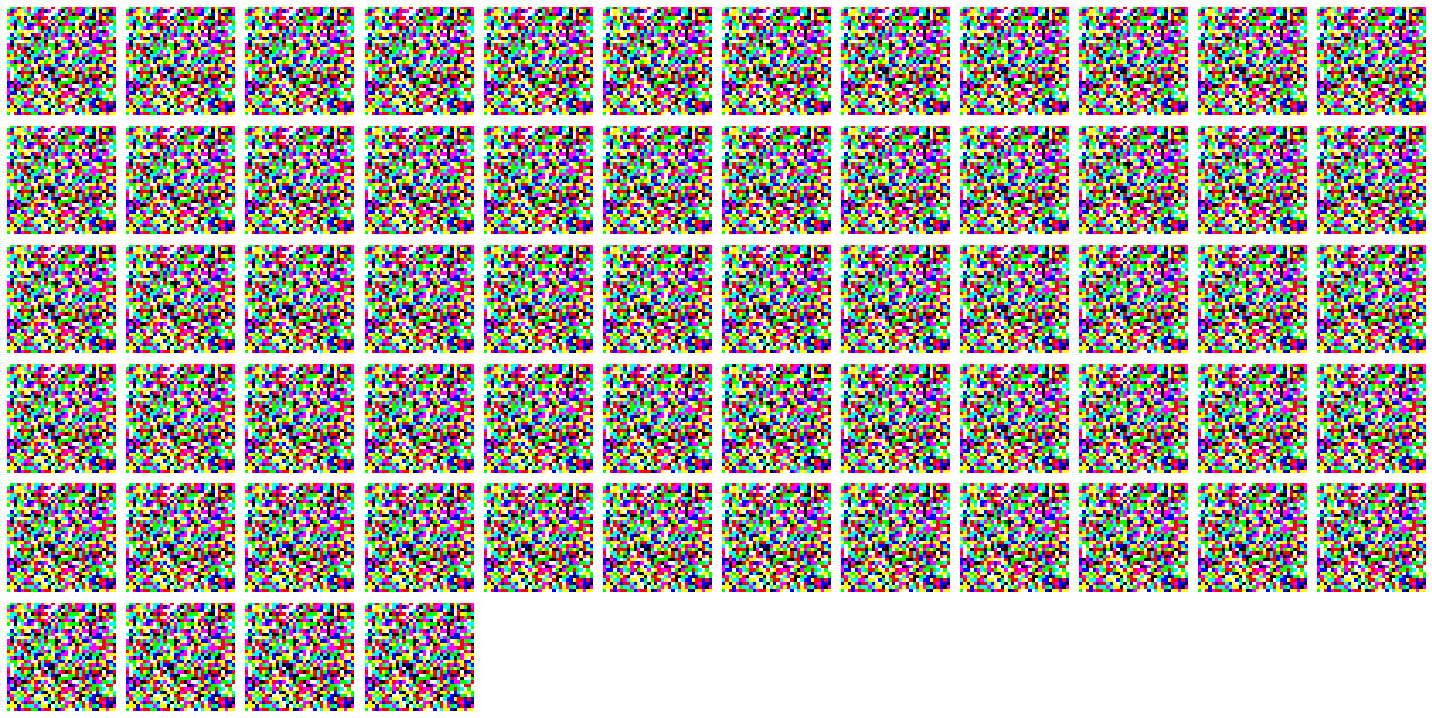

Epoch 24
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


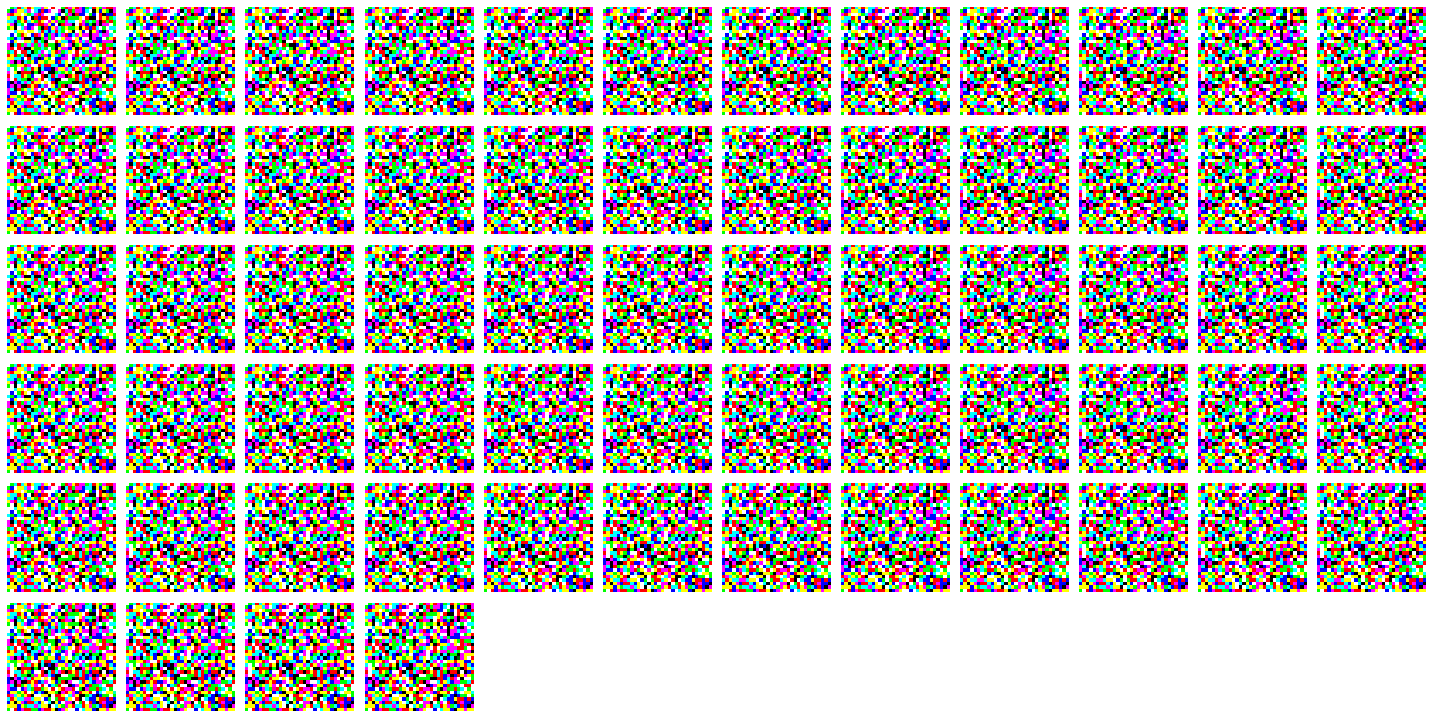

Epoch 25
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


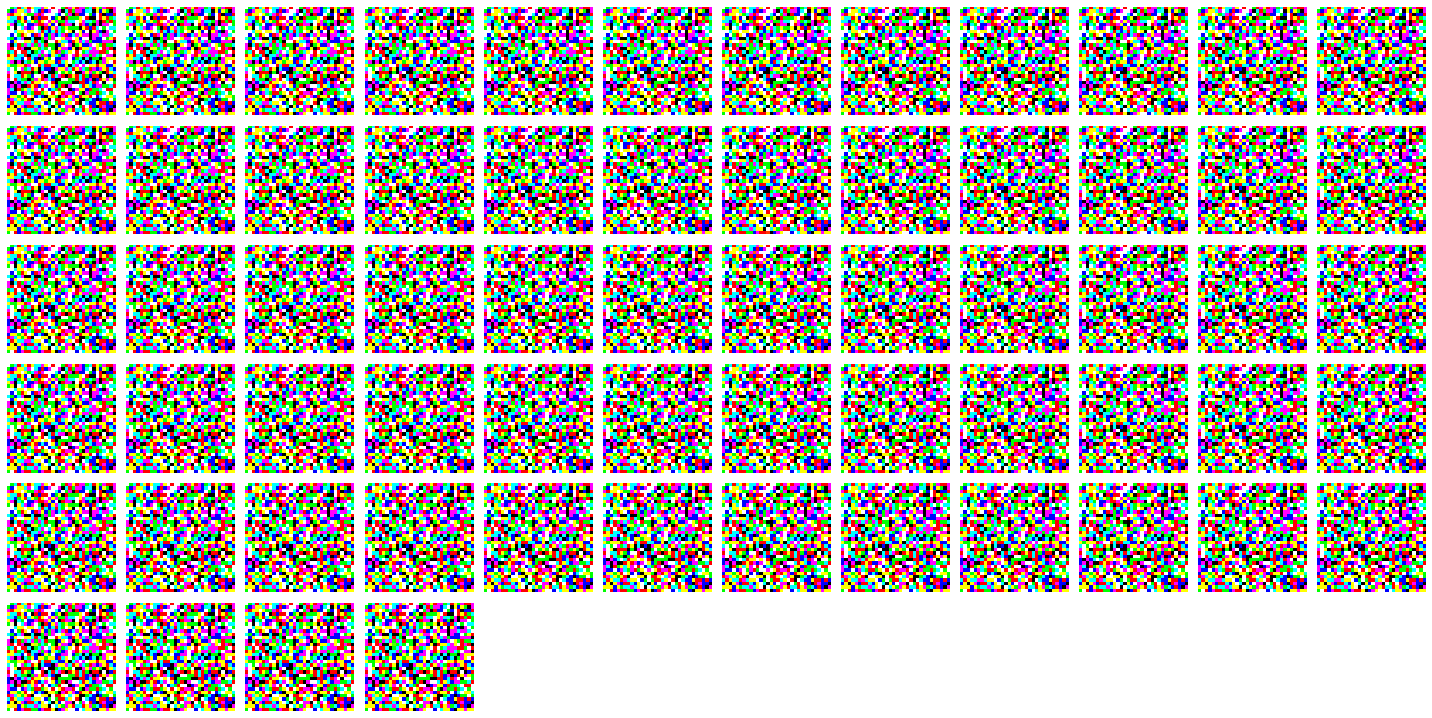

Epoch 26
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


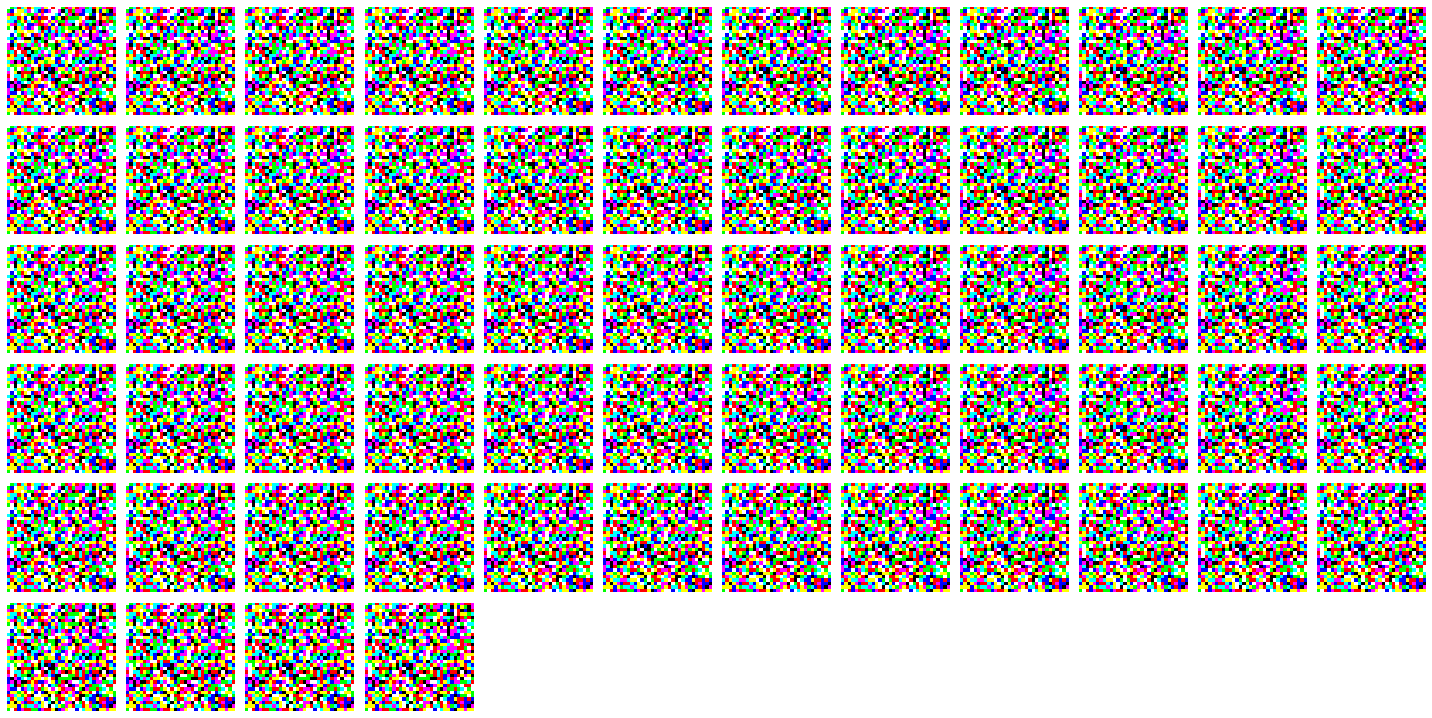

Epoch 27
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


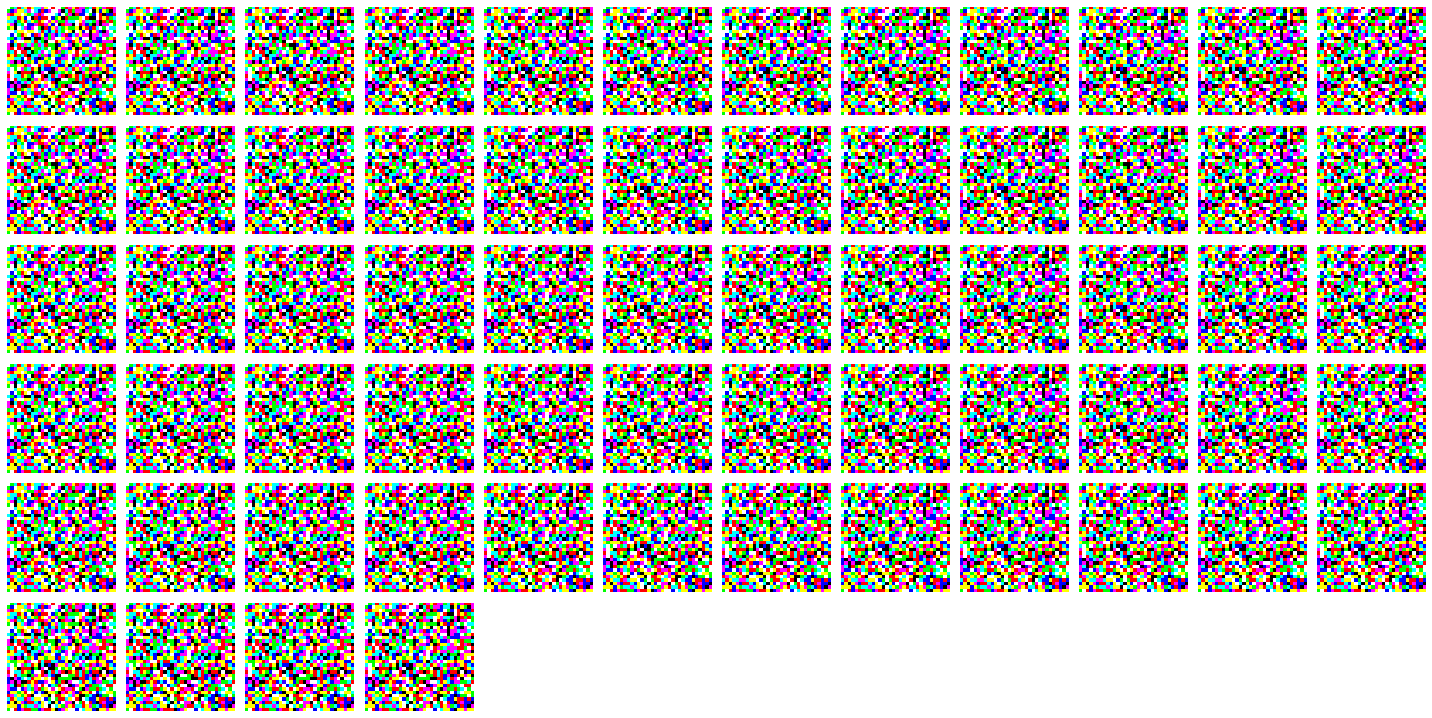

Epoch 28
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


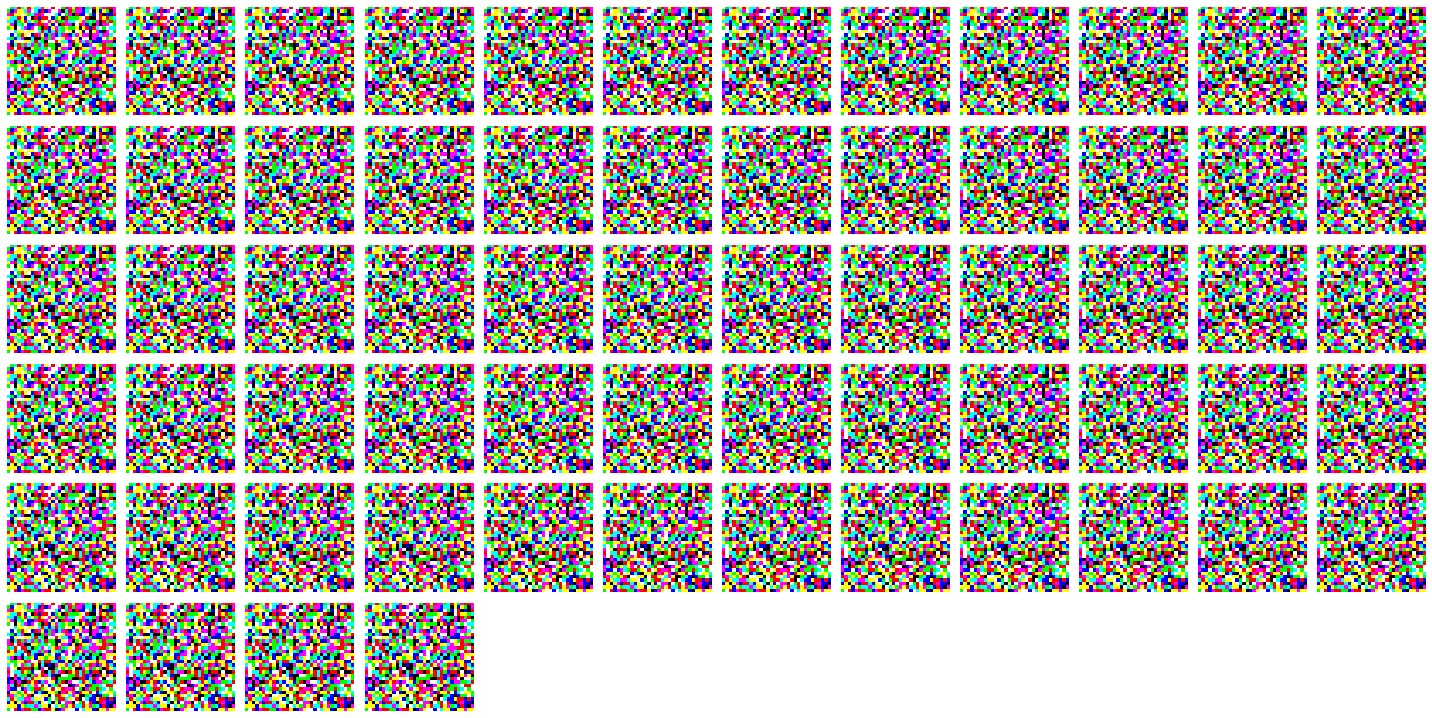

Epoch 29
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


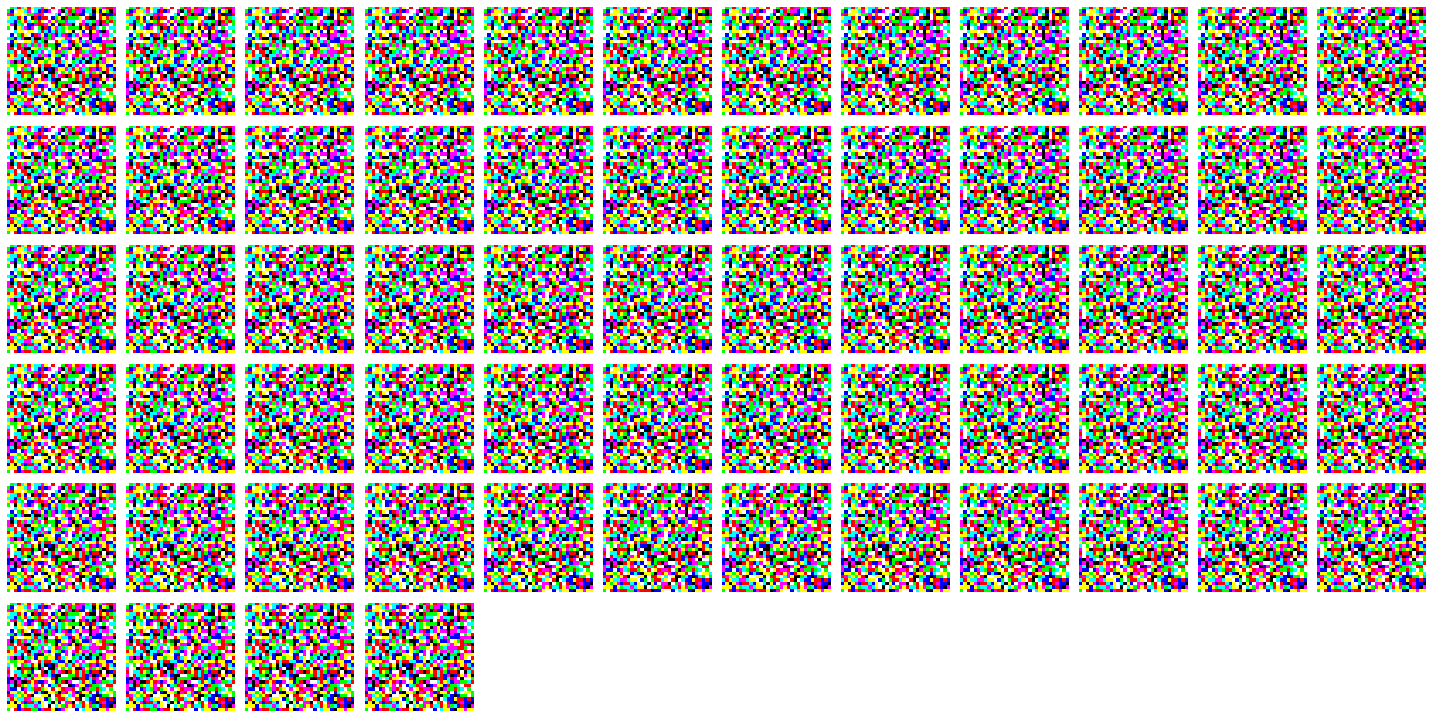

Epoch 30
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


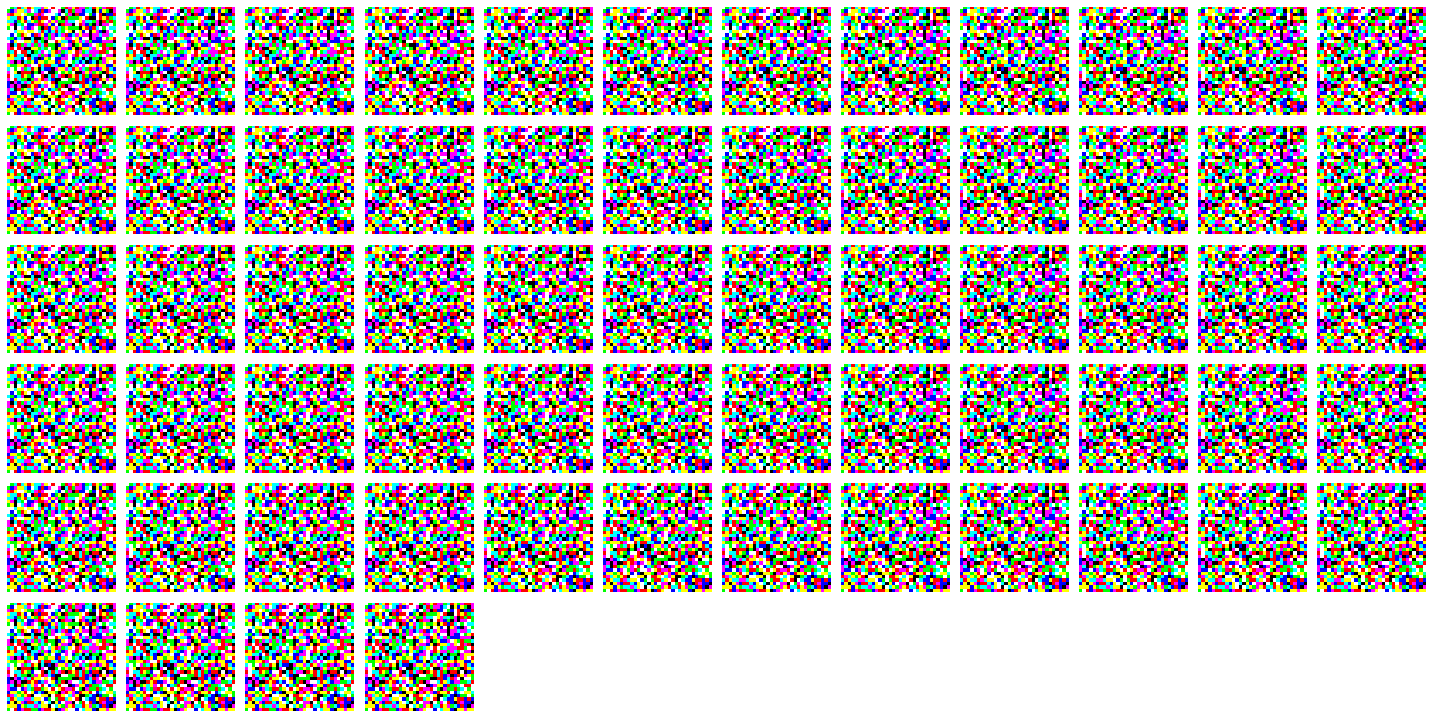

Epoch 31
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


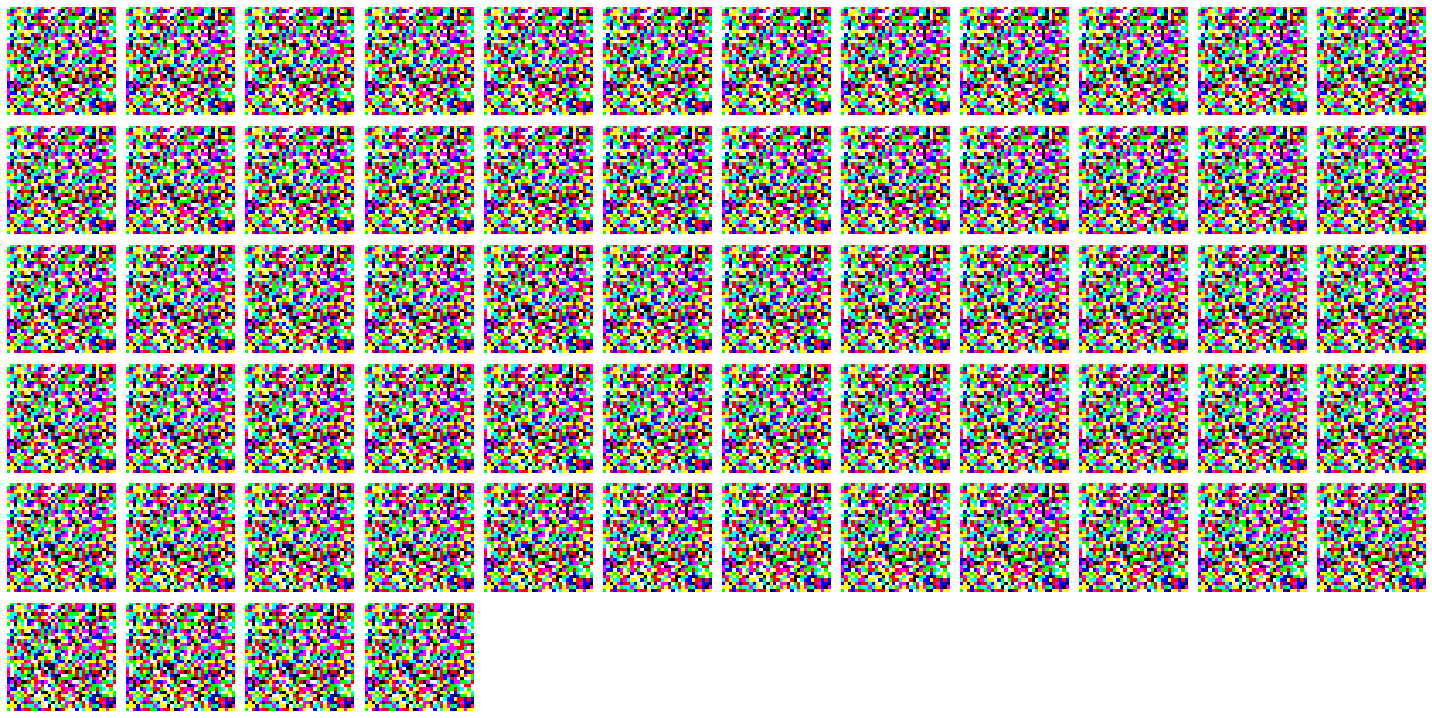

Epoch 32
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


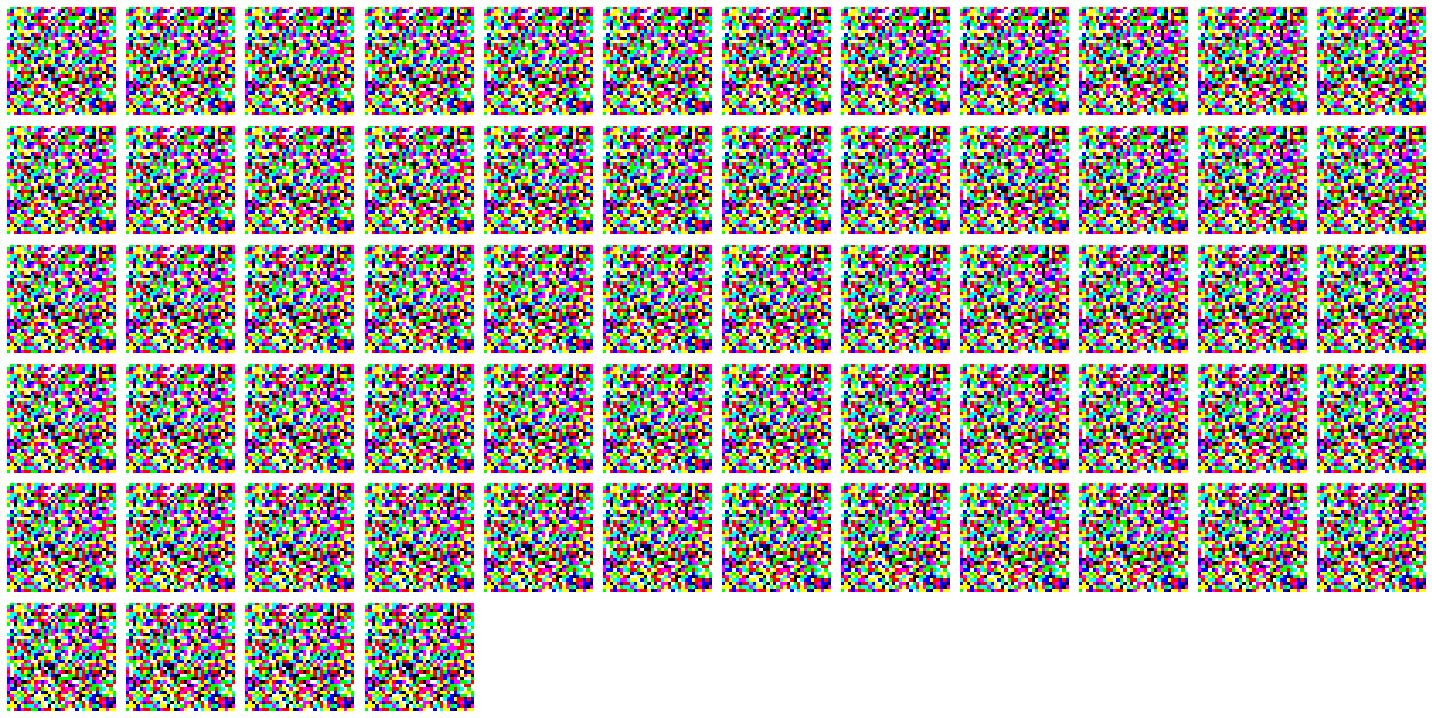

Epoch 33
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


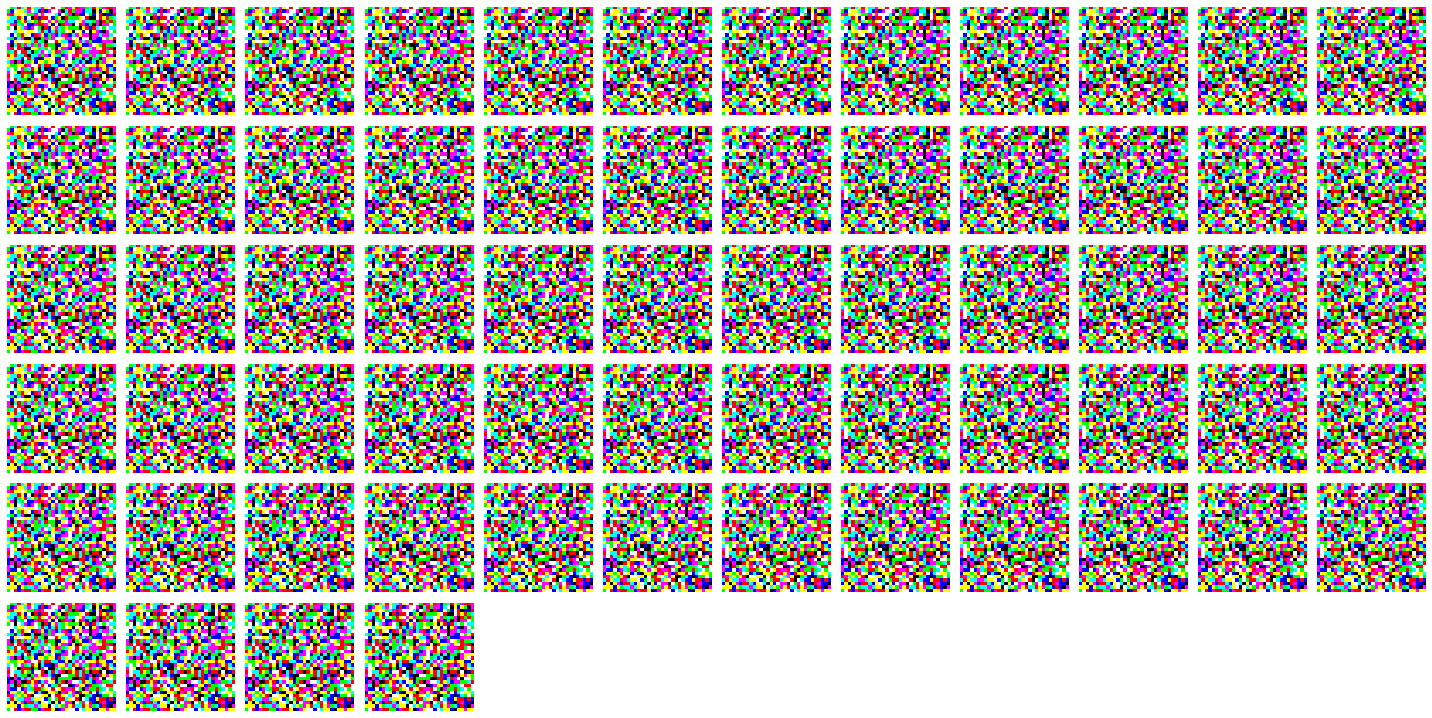

Epoch 34
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


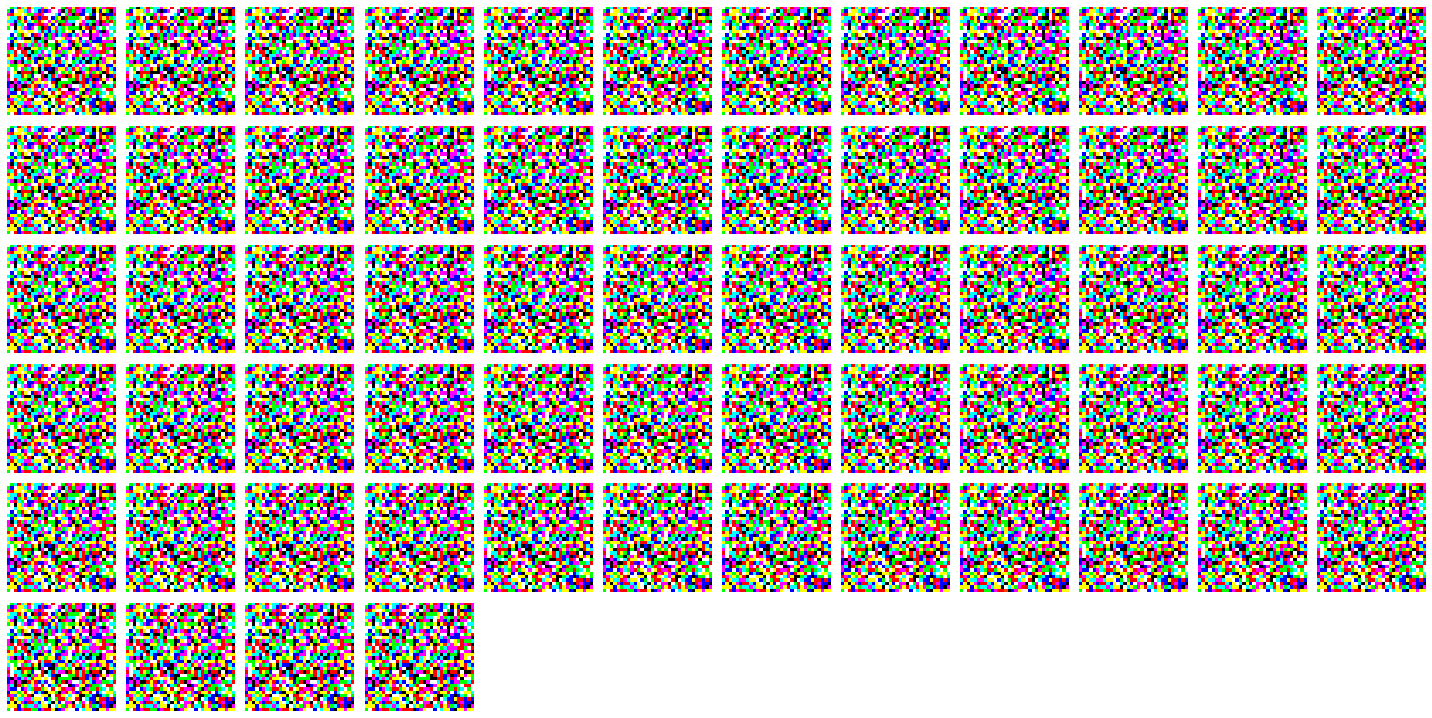

Epoch 35
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


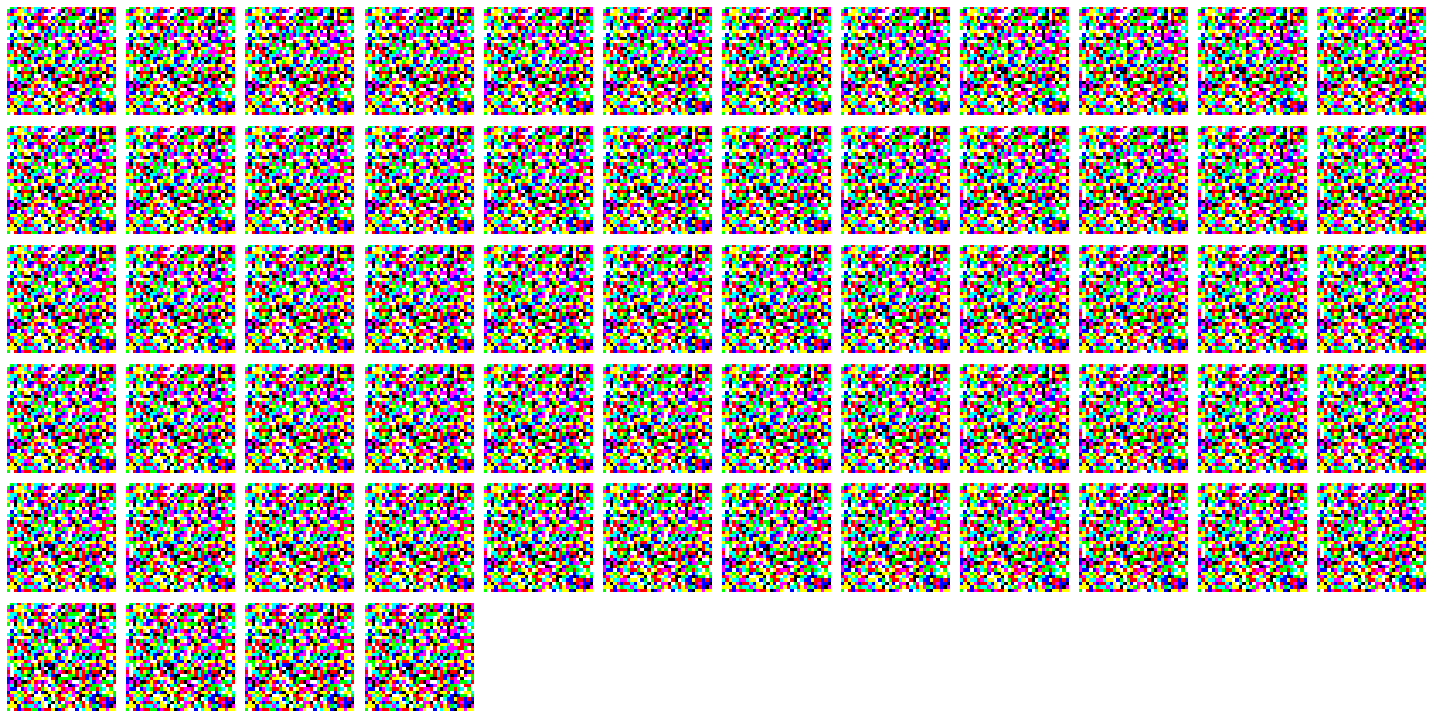

Epoch 36
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


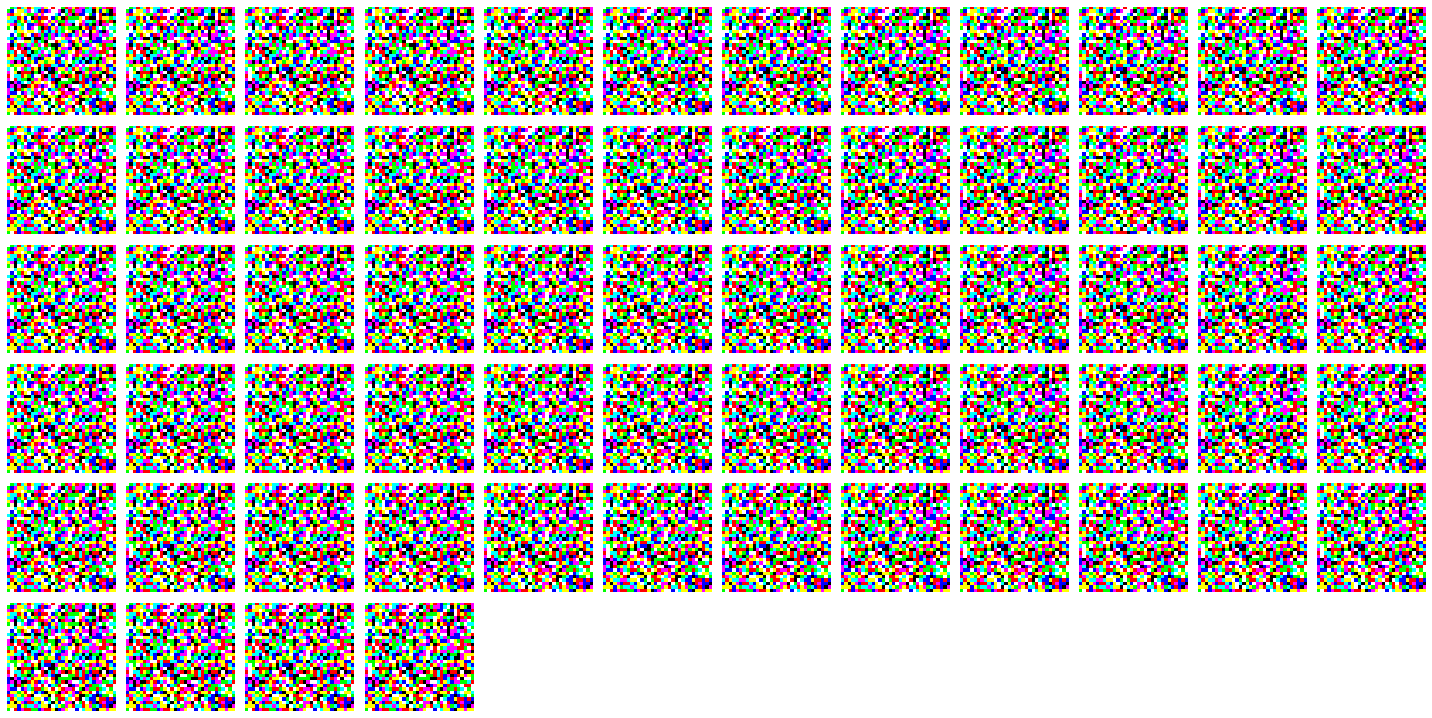

Epoch 37
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


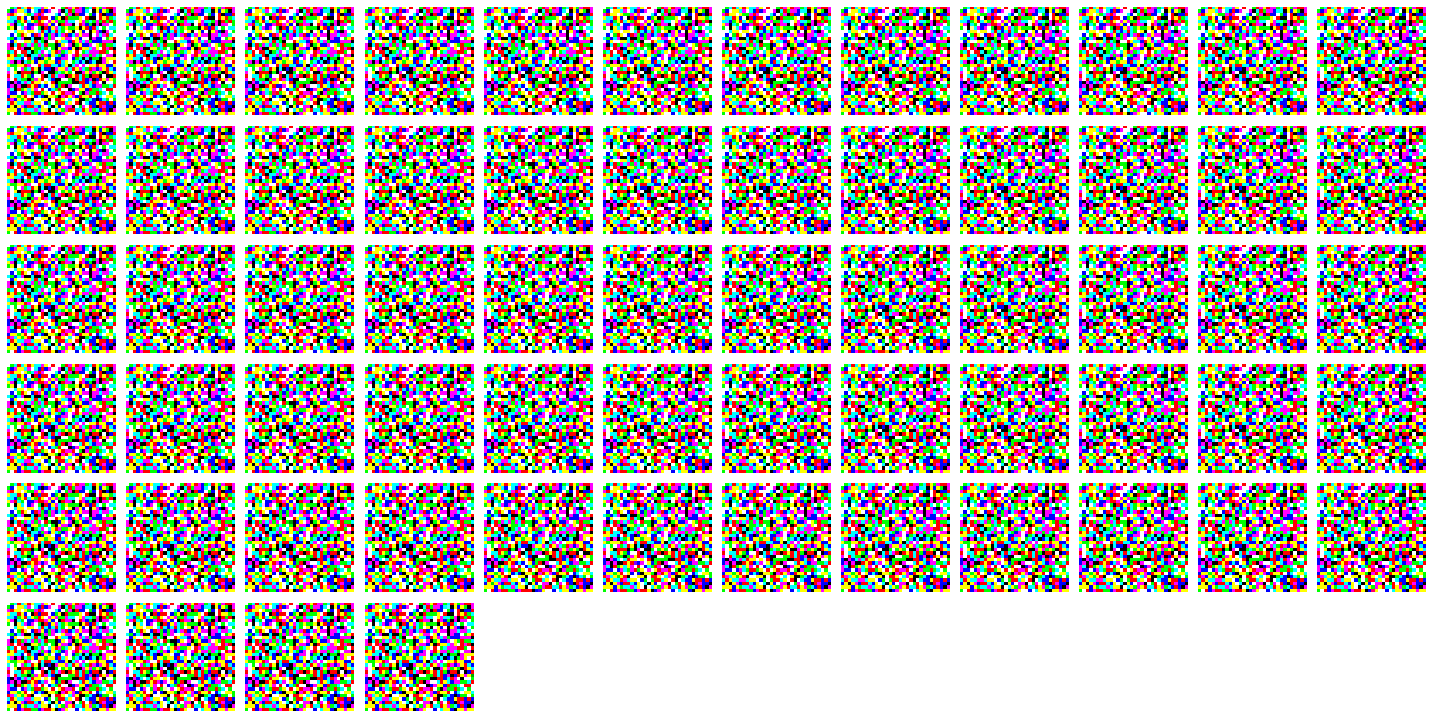

Epoch 38
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


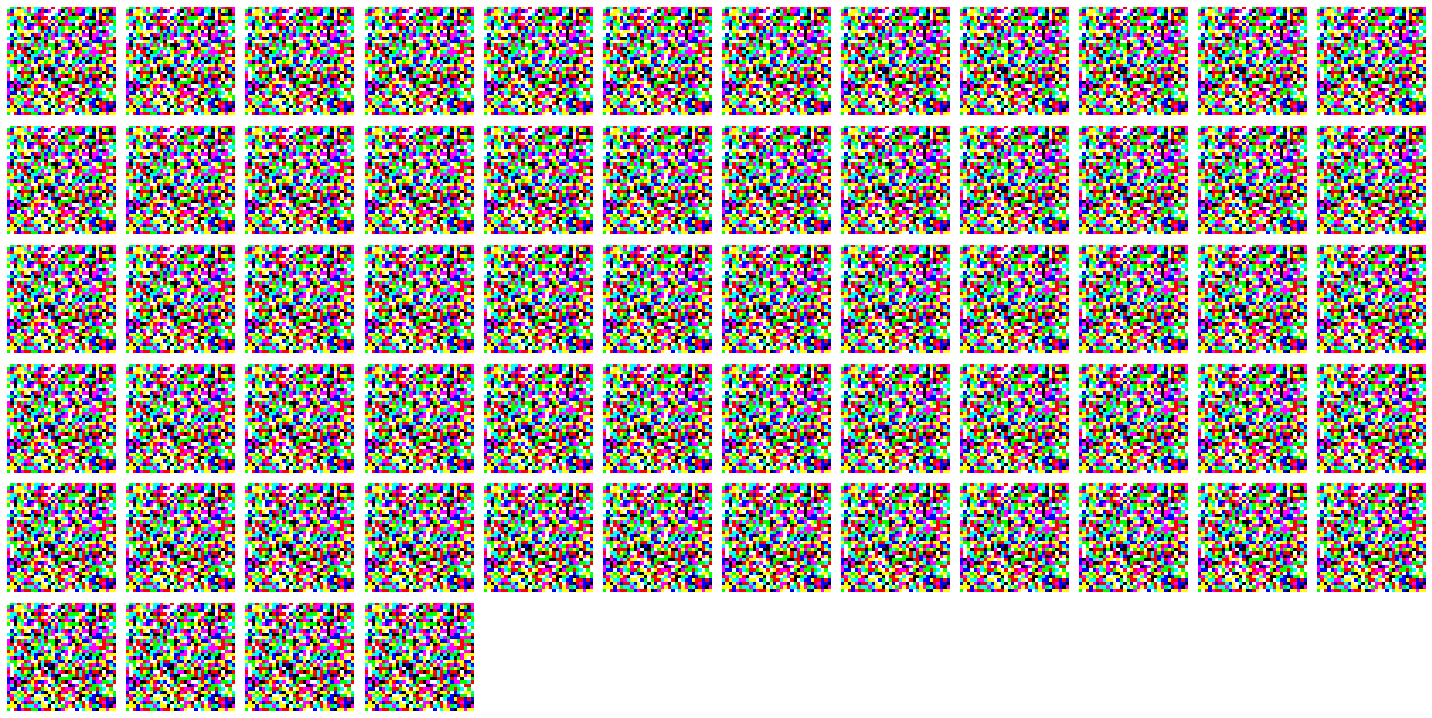

Epoch 39
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


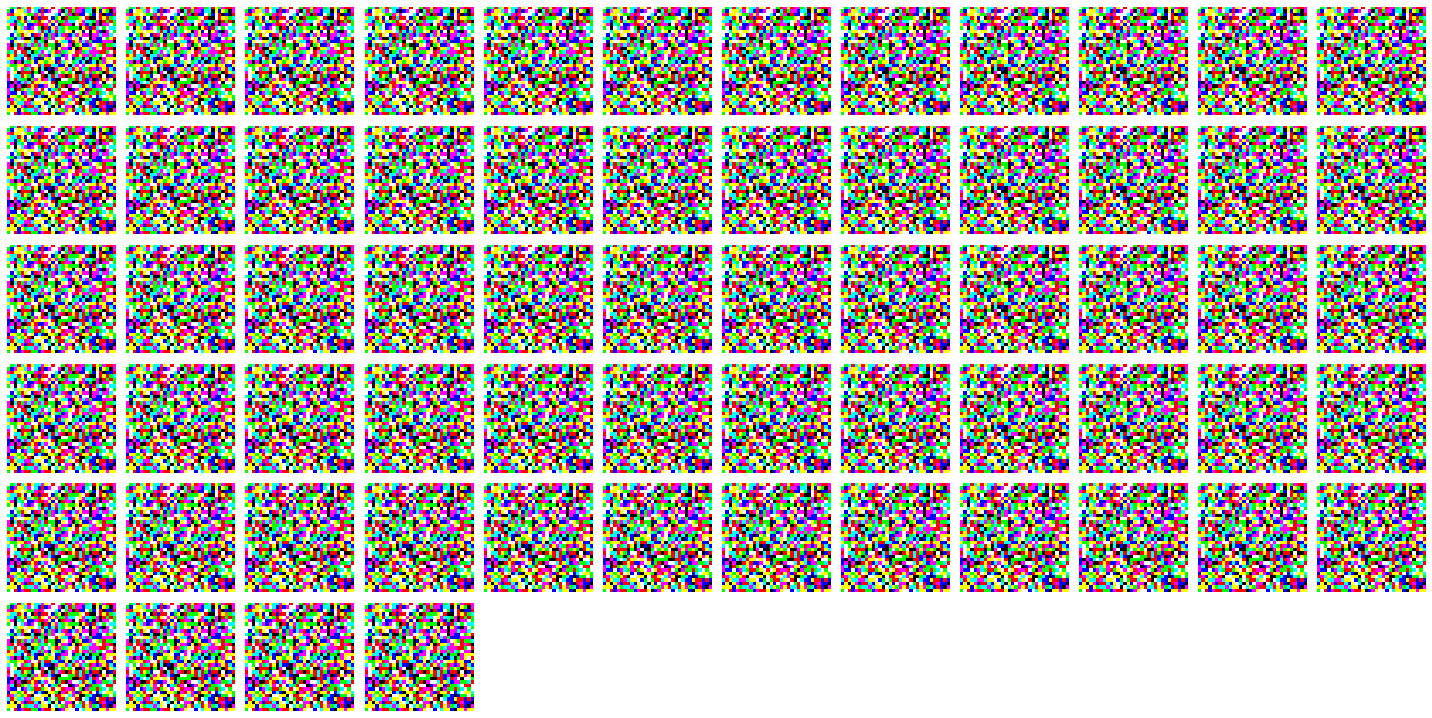

Epoch 40
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


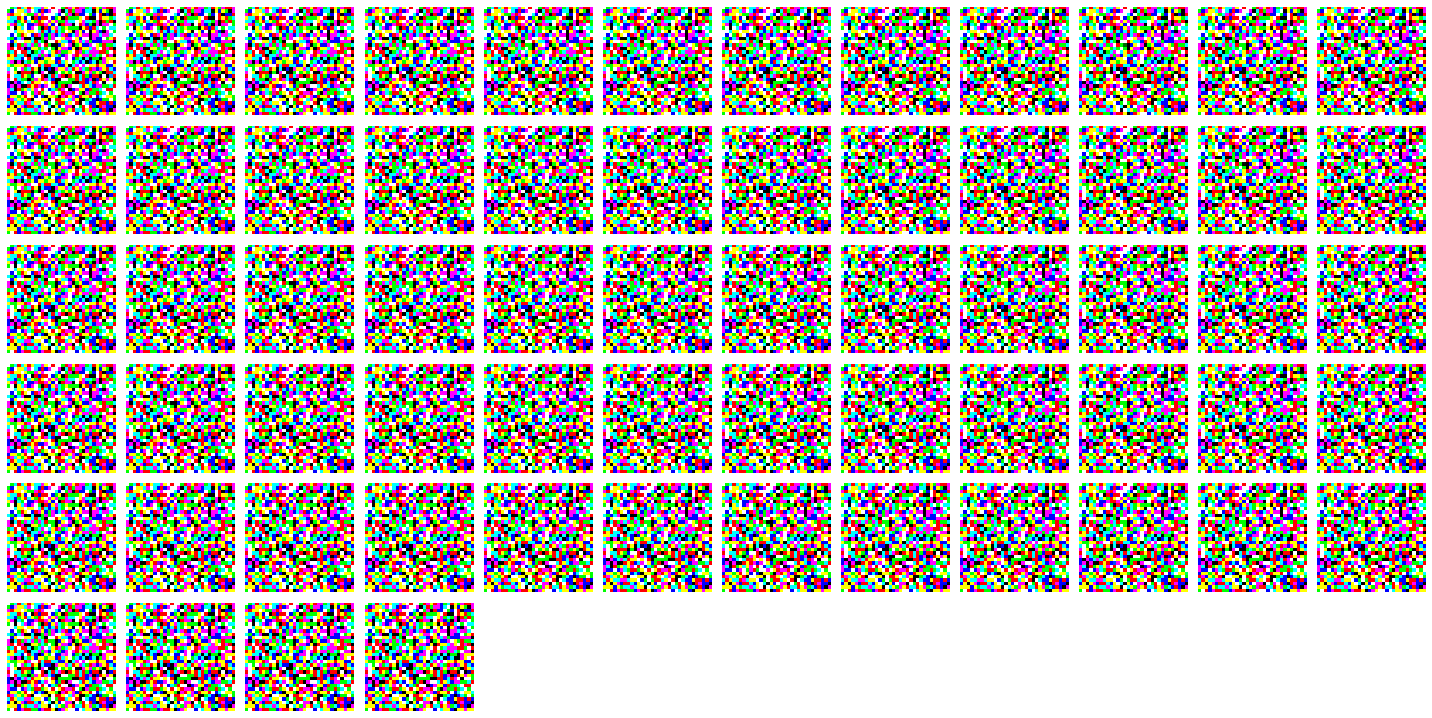

Epoch 41
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


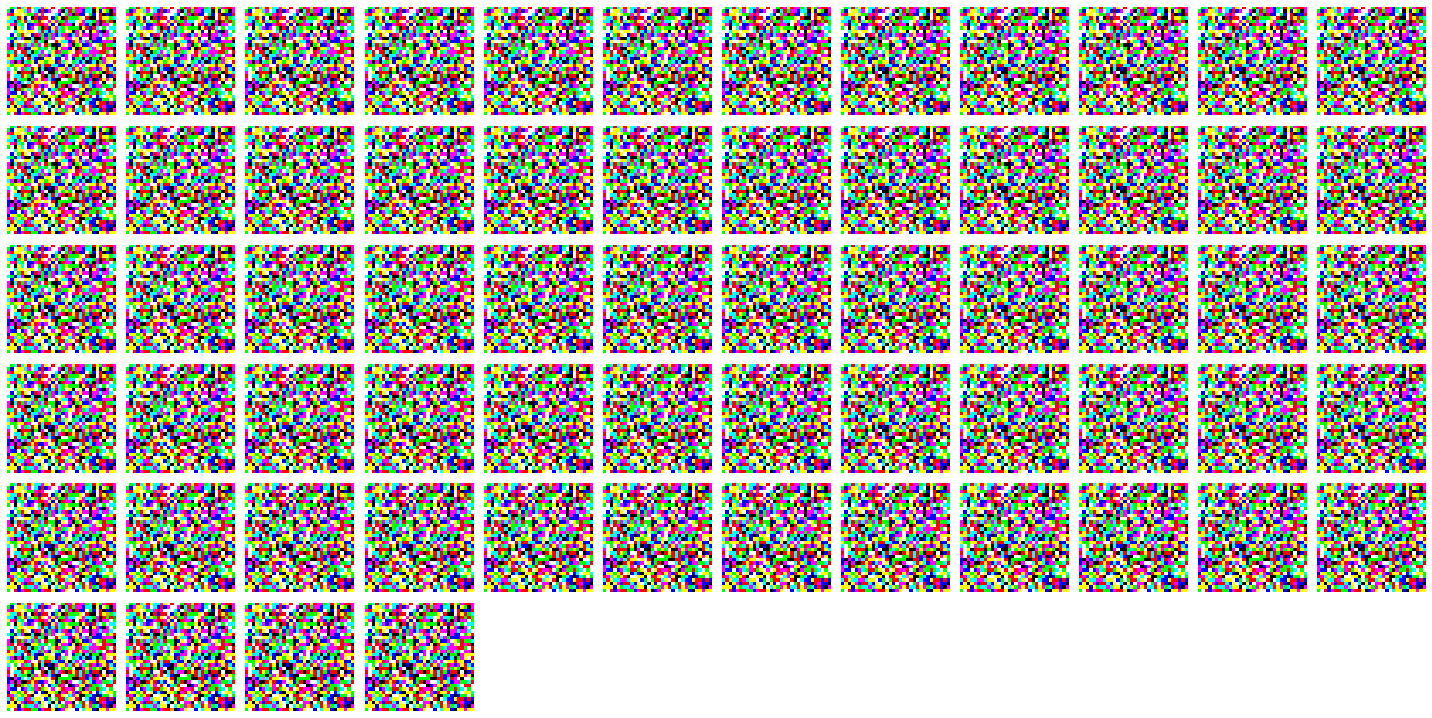

Epoch 42
0.0 %
11.024978466838933 %
22.049956933677866 %
33.0749354005168 %
44.09991386735573 %
55.12489233419466 %
66.1498708010336 %
77.17484926787253 %
88.19982773471146 %


KeyboardInterrupt: 

In [19]:


training(1000)